# Copyright Netherlands eScience Center <br>
** Function     : Predict the Spatial Sea Ice Concentration with ConvLSTM at weekly time scale** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.05.21 ** <br>
** Last Update  : 2019.07.21 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, deepclim, matplotlib **<br>
Description     : This notebook serves to predict the Arctic sea ice using deep learning. We also include many climate index (to represent the forcing from atmosphere). The convolutional Long Short Time Memory neural network is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>
<br>
** Here we predict sea ice concentration with one extra relevant field from either ocean or atmosphere to test the predictor.** <br>

Return Values   : Time series and figures <br>

Here is the information of climate index in details:<br>
**NAO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/nao.shtml <br>
**ENSO - NINO 3.4 SST** @ 1950 Jan - 2018 Jan (817 records) <br>
https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/ <br>
**AO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/ao.shtml <br>
**AMO** @ 1950 Jan - 2018 Feb (818 records) <br>
AMO unsmoothed, detrended from the Kaplan SST V2. The result is standarised.<br>
https://www.esrl.noaa.gov/psd/data/timeseries/AMO/<br>

(All the NOAA index shown above are given by NCEP/NCAR Reanalysis (CDAS))<br>

**PDO** @ 1900 Jan - 2018 Feb (1418 records)<br>
This PDO index comes from University of Washington, it contains SST data from the following 3 datasets:<br>
- UKMO Historical SST data set for 1900-81;
- Reynold's Optimally Interpolated SST (V1) for January 1982-Dec 2001)
- OI SST Version 2 (V2) beginning January 2002 -<br>

http://research.jisao.washington.edu/pdo/PDO.latest<br>

The regionalization adopted here follows that of the MASIE (Multisensor Analyzed Sea Ice Extent) product available from the National Snow and Ice Data Center:<br>
https://nsidc.org/data/masie/browse_regions<br>
It is given by paper J.Walsh et. al., 2019. Benchmark seasonal prediction skill estimates based on regional indices.<br>

The method comes from the study by Shi et. al. (2015) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. <br>

In [1]:
%matplotlib inline

import sys
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DeepClim'))
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DeepClim")
import deepclim
import deepclim.preprocess
import deepclim.deepSeries
import deepclim.deepArray
#import deepclim.deepArrayStep
#import deepclim.function

# for visualization
import deepclim.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

** Data ** <br>
Time span of each product included: <br>
** Reanalysis ** <br>
- **ERA-Interim** 1979 - 2016 (ECMWF)
- **ORAS4**       1958 - 2014 (ECMWF)

** Index ** <br>
- **NINO3.4**     1950 - 2017 (NOAA)
- **AO**          1950 - 2017 (NOAA)
- **NAO**         1950 - 2017 (NOAA)
- **AMO**         1950 - 2017 (NOAA)
- **PDO**         1950 - 2017 (University of Washington)

!! These index are given by NCEP/NCAR Reanalysis (CDAS) <br>


Alternative (not in use yet) <br>
** Reanalysis ** <br>
- **MERRA2**      1980 - 2016 (NASA)
- **JRA55**       1979 - 2015 (JMA)
- **GLORYS2V3**   1993 - 2014 (Mercartor Ocean)
- **SODA3**       1980 - 2015
- **PIOMASS**     1980 - 2015

** Observations ** <br>
- **NSIDC**       1958 - 2017 

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# please specify data path
#datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim'
datapath_ERAI = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ERA-Interim'
#datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ORAS4'
datapath_ORAS4 = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ORAS4'
#datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
datapath_ORAS4_mask = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ORAS4'
#datapath_PIOMASS = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/PIOMASS'
datapath_PIOMASS = 'H:\\Creator_Zone\\Core_Database_AMET_OMET_reanalysis\\PIOMASS'
#datapath_clim_index = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/Climate_index'
datapath_clim_index = 'F:\\PhD_essential\\Core_Database_AMET_OMET_reanalysis\\Climate_index'
#output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Maps'
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\Maps'

In [4]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    # weekly variables on ERAI grid
    dataset_ERAI_fields_sic = Dataset(os.path.join(datapath_ERAI,
                                      'sic_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_slp = Dataset(os.path.join(datapath_ERAI,
                                      'slp_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_t2m = Dataset(os.path.join(datapath_ERAI,
                                      't2m_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_z500 = Dataset(os.path.join(datapath_ERAI,
                                       'z500_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_z850 = Dataset(os.path.join(datapath_ERAI,
                                       'z850_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_uv10m = Dataset(os.path.join(datapath_ERAI,
                                       'uv10m_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_rad = Dataset(os.path.join(datapath_ERAI,
                                        'rad_flux_weekly_erai_1979_2017.nc'))
    #dataset_PIOMASS_siv = Dataset(os.path.join(datapath_PIOMASS,
    #                             'siv_monthly_PIOMASS_1979_2017.nc'))
    # OHC interpolated on ERA-Interim grid
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath_ORAS4,
                                'ohc_monthly_oras2erai_1978_2017.nc'))
    dataset_index = Dataset(os.path.join(datapath_clim_index,
                            'index_climate_monthly_regress_1950_2017.nc'))
    #dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
    #                                  'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # mask
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    print ('*********************** extract variables *************************')
    #################################################################################
    #########                        data gallery                           #########
    #################################################################################
    # we use time series from 1979 to 2016 (468 months in total)
    # training data: 1979 - 2013
    # validation: 2014 - 2016
    # variables list:
    # SIC (ERA-Interim) / SIV (PIOMASS) / SST (ERA-Interim) / ST (ERA-Interim) / OHC (ORAS4) / AO-NAO-AMO-NINO3.4 (NOAA)
    # integrals from spatial fields cover the area from 20N - 90N (4D fields [year, month, lat, lon])
    # *************************************************************************************** #
    # SIC (ERA-Interim) - benckmark
    SIC_ERAI = dataset_ERAI_fields_sic.variables['sic'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI = dataset_ERAI_fields_sic.variables['year'][:-1]
    week_ERAI = dataset_ERAI_fields_sic.variables['week'][:]
    latitude_ERAI = dataset_ERAI_fields_sic.variables['latitude'][:]
    longitude_ERAI = dataset_ERAI_fields_sic.variables['longitude'][:]
    # T2M (ERA-Interim)
    T2M_ERAI = dataset_ERAI_fields_t2m.variables['t2m'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_t2m = dataset_ERAI_fields_t2m.variables['year'][:-1]
    week_ERAI_t2m = dataset_ERAI_fields_t2m.variables['week'][:]
    latitude_ERAI_t2m = dataset_ERAI_fields_t2m.variables['latitude'][:]
    longitude_ERAI_t2m = dataset_ERAI_fields_t2m.variables['longitude'][:]
    # SLP (ERA-Interim)
    SLP_ERAI = dataset_ERAI_fields_slp.variables['slp'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_slp = dataset_ERAI_fields_slp.variables['year'][:-1]
    week_ERAI_slp = dataset_ERAI_fields_slp.variables['week'][:]
    latitude_ERAI_slp = dataset_ERAI_fields_slp.variables['latitude'][:]
    longitude_ERAI_slp = dataset_ERAI_fields_slp.variables['longitude'][:]
    # Z500 (ERA-Interim)
    Z500_ERAI = dataset_ERAI_fields_z500.variables['z'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_z500 = dataset_ERAI_fields_z500.variables['year'][:-1]
    week_ERAI_z500 = dataset_ERAI_fields_z500.variables['week'][:]
    latitude_ERAI_z500 = dataset_ERAI_fields_z500.variables['latitude'][:]
    longitude_ERAI_z500 = dataset_ERAI_fields_z500.variables['longitude'][:]
    # Z850 (ERA-Interim)
    Z850_ERAI = dataset_ERAI_fields_z850.variables['z'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_z850 = dataset_ERAI_fields_z850.variables['year'][:-1]
    week_ERAI_z850 = dataset_ERAI_fields_z850.variables['week'][:]
    latitude_ERAI_z850 = dataset_ERAI_fields_z850.variables['latitude'][:]
    longitude_ERAI_z850 = dataset_ERAI_fields_z850.variables['longitude'][:]
    # UV10M (ERA-Interim)
    U10M_ERAI = dataset_ERAI_fields_uv10m.variables['u10m'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    V10M_ERAI = dataset_ERAI_fields_uv10m.variables['v10m'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['year'][:-1]
    week_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['week'][:]
    latitude_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['latitude'][:]
    longitude_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['longitude'][:]
    # SFlux (ERA-Interim)
    SFlux_ERAI = dataset_ERAI_fields_rad.variables['SFlux'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_SFlux = dataset_ERAI_fields_rad.variables['year'][:-1]
    week_ERAI_SFlux = dataset_ERAI_fields_rad.variables['week'][:]
    latitude_ERAI_SFlux = dataset_ERAI_fields_rad.variables['latitude'][:]
    longitude_ERAI_SFlux = dataset_ERAI_fields_rad.variables['longitude'][:]
    #SIV (PIOMASS)
    #SIV_PIOMASS = dataset_PIOMASS_siv.variables['SIV'][:-12]
    #year_SIV = dataset_PIOMASS_siv.variables['year'][:-1]
    # OHC (ORAS4)
    # from 1978 - 2017 (for interpolation) / from 90 N upto 40 N
    OHC_300_ORAS4 = dataset_ORAS4_OHC.variables['OHC'][:-1,:,:67,:]/1000 # unit Peta Joule
    latitude_ORAS4 = dataset_ORAS4_OHC.variables['latitude'][:]
    longitude_ORAS4 = dataset_ORAS4_OHC.variables['longitude'][:]
    mask_OHC = np.ma.getmask(OHC_300_ORAS4[0,0,:,:])
    # AO-NAO-AMO-NINO3.4 (NOAA)
    AO = dataset_index.variables['AO'][348:-1] # from 1979 - 2017
    NAO = dataset_index.variables['NAO'][348:-1]
    NINO = dataset_index.variables['NINO'][348:-1]
    AMO = dataset_index.variables['AMO'][348:-1]
    PDO = dataset_index.variables['PDO'][348:-1]

*********************** get the key to the datasets *************************
*********************** extract variables *************************


In [9]:
    # first check of grid
    print(latitude_ERAI)
    print(longitude_ERAI)
    print(latitude_ERAI_t2m)
    print(longitude_ERAI_t2m)
    print(longitude_ORAS4)

[89.5  88.75 88.   87.25 86.5  85.75 85.   84.25 83.5  82.75 82.   81.25
 80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25
 62.5  61.75 61.   60.25 59.5  58.75 58.   57.25 56.5  55.75 55.   54.25
 53.5  52.75 52.   51.25 50.5  49.75 49.   48.25 47.5  46.75 46.   45.25
 44.5  43.75 43.   42.25 41.5  40.75 40.  ]
[-180.   -179.25 -178.5  -177.75 -177.   -176.25 -175.5  -174.75 -174.
 -173.25 -172.5  -171.75 -171.   -170.25 -169.5  -168.75 -168.   -167.25
 -166.5  -165.75 -165.   -164.25 -163.5  -162.75 -162.   -161.25 -160.5
 -159.75 -159.   -158.25 -157.5  -156.75 -156.   -155.25 -154.5  -153.75
 -153.   -152.25 -151.5  -150.75 -150.   -149.25 -148.5  -147.75 -147.
 -146.25 -145.5  -144.75 -144.   -143.25 -142.5  -141.75 -141.   -140.25
 -139.5  -138.75 -138.   -137.25 -136.5  -135.75 -135.   -134.25 -133.5
 -132.75 -132.   -131.25 -130.5  -129.75 -129.   -128.25 -127.5  -126.75
 -126.   -125

In [5]:
    #################################################################################
    ###########                regionalization sea mask                   ###########
    #################################################################################
    print ('*********************** create mask *************************')
    # W:-156 E:-124 N:80 S:67
    mask_Beaufort = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:-156 N:80 S:66
    mask_Chukchi = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:146 E:180 N:80 S:67
    mask_EastSiberian = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:100 E:146 N:80 S:67
    mask_Laptev = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:60 E:100 N:80 S:67
    mask_Kara = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:18 E:60 N:80 S:64
    mask_Barents = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-44 E:18 N:80 S:55
    mask_Greenland = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:180 N:90 S:80
    mask_CenArctic = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    print ('*********************** calc mask *************************')
    mask_Beaufort[13:31,32:76] = 1

    mask_Chukchi[13:32,0:32] = 1
    mask_Chukchi[13:32,-1] = 1

    mask_EastSiberian[13:31,434:479] = 1

    mask_Laptev[13:31,374:434] = 1

    mask_Kara[13:31,320:374] = 1

    mask_Barents[13:36,264:320] = 1

    mask_Greenland[13:47,179:264] = 1
    mask_Greenland[26:47,240:264] = 0

    mask_CenArctic[:13,:] = 1
    print ('*********************** packing *************************')
    mask_dict = {'Beaufort': mask_Beaufort[:,:],
                 'Chukchi': mask_Chukchi[:,:],
                 'EastSiberian': mask_EastSiberian[:,:],
                 'Laptev': mask_Laptev[:,:],
                 'Kara': mask_Kara[:,:],
                 'Barents': mask_Barents[:,:],
                 'Greenland': mask_Greenland[:,:],
                 'CenArctic': mask_CenArctic[:,:]}
    seas_namelist = ['Beaufort','Chukchi','EastSiberian','Laptev',
                     'Kara', 'Barents', 'Greenland','CenArctic']

*********************** create mask *************************
*********************** calc mask *************************
*********************** packing *************************


In [6]:
    #################################################################################
    ########                  temporal interpolation matrix                  ########
    #################################################################################
    # interpolate from monthly to weekly
    # original monthly data will be taken as the last week of the month
    OHC_300_ORAS4_weekly_series = np.zeros(SIC_ERAI.reshape(len(year_ERAI)*48,len(latitude_ERAI),len(longitude_ERAI)).shape,
                                           dtype=float)
    OHC_300_ORAS4_series= deepclim.preprocess.operator.unfold(OHC_300_ORAS4)
    # calculate the difference between two months
    OHC_300_ORAS4_deviation_series = (OHC_300_ORAS4_series[1:,:,:] - OHC_300_ORAS4_series[:-1,:,:]) / 4
    for i in np.arange(4):
        OHC_300_ORAS4_weekly_series[3-i::4,:,:] = OHC_300_ORAS4_series[12:,:,:] - i * OHC_300_ORAS4_deviation_series[11:,:,:]

In [7]:
    print ('******************  calculate extent from spatial fields  *******************')
    # size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
                                            360) / len(longitude_ERAI)
    dy = np.pi * constant['R'] / 480
    # calculate the sea ice area
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
    SFlux_ERAI_area = np.zeros(SFlux_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_ERAI[:])):
        # change the unit to terawatt
        SIC_ERAI_area[:,:,i,:] = SIC_ERAI[:,:,i,:]* dx[i] * dy / 1E+6 # unit km2
        SFlux_ERAI_area[:,:,i,:] = SFlux_ERAI[:,:,i,:]* dx[i] * dy / 1E+12 # unit TeraWatt
    SIC_ERAI_area[SIC_ERAI_area<0] = 0 # switch the mask from -1 to 0
    print ('================  reshape input data into time series  =================')
    SIC_ERAI_area_series = deepclim.preprocess.operator.unfold(SIC_ERAI_area)
    T2M_ERAI_series = deepclim.preprocess.operator.unfold(T2M_ERAI)
    SLP_ERAI_series = deepclim.preprocess.operator.unfold(SLP_ERAI)
    Z500_ERAI_series = deepclim.preprocess.operator.unfold(Z500_ERAI)
    Z850_ERAI_series = deepclim.preprocess.operator.unfold(Z850_ERAI)
    U10M_ERAI_series = deepclim.preprocess.operator.unfold(U10M_ERAI)
    V10M_ERAI_series = deepclim.preprocess.operator.unfold(V10M_ERAI)
    SFlux_ERAI_area_series = deepclim.preprocess.operator.unfold(SFlux_ERAI_area)

******************  calculate extent from spatial fields  *******************
================  reshape input data into time series  =================


In [8]:
    print ('******************  choose the fields from target region  *******************')
    # select the area between greenland and ice land for instance 60-70 N / 44-18 W
    sic_exp = SIC_ERAI_area_series[:,12:36,264:320]
    t2m_exp = T2M_ERAI_series[:,12:36,264:320]
    slp_exp = SLP_ERAI_series[:,12:36,264:320]
    z500_exp = Z500_ERAI_series[:,12:36,264:320]
    z850_exp = Z850_ERAI_series[:,12:36,264:320]
    u10m_exp = U10M_ERAI_series[:,12:36,264:320]
    v10m_exp = V10M_ERAI_series[:,12:36,264:320]
    sflux_exp = SFlux_ERAI_area_series[:,12:36,264:320]
    ohc_exp = OHC_300_ORAS4_weekly_series[:,12:36,264:320]
    print(sic_exp.shape)
    print(t2m_exp.shape)
    print(slp_exp.shape)
    print(z500_exp.shape)
    print(u10m_exp.shape)
    print(v10m_exp.shape)
    print(sflux_exp.shape)
    print(ohc_exp.shape)
    print(latitude_ERAI[12:36])
    print(longitude_ERAI[264:320])
    print(latitude_ORAS4[12:36])
    print(longitude_ORAS4[264:320])
    #print(latitude_ERAI[26:40])
    #print(longitude_ERAI[180:216])

******************  choose the fields from target region  *******************
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  38.25 39.   39.75 40.5  41.25 42.   42.75 43.5  44.25
 45.   45.75 46.5  47.25 48.   48.75 49.5  50.25 51.   51.75 52.5  53.25
 54.   54.75 55.5  56.25 57.   57.75 58.5  59.25]
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  3

In [9]:
    print ('*******************  pre-processing  *********************')
    print ('=========================   normalize data   ===========================')
    sic_exp_norm = deepclim.preprocess.operator.normalize(sic_exp)
    t2m_exp_norm = deepclim.preprocess.operator.normalize(t2m_exp)
    slp_exp_norm = deepclim.preprocess.operator.normalize(slp_exp)
    z500_exp_norm = deepclim.preprocess.operator.normalize(z500_exp)
    z850_exp_norm = deepclim.preprocess.operator.normalize(z850_exp)
    u10m_exp_norm = deepclim.preprocess.operator.normalize(u10m_exp)
    v10m_exp_norm = deepclim.preprocess.operator.normalize(v10m_exp)
    sflux_exp_norm = deepclim.preprocess.operator.normalize(sflux_exp)
    ohc_exp_norm = deepclim.preprocess.operator.normalize(ohc_exp)
    _, yy, xx = sic_exp_norm.shape # get the lat lon dimension for 
    print ('====================    A series of time (index)    ====================')
    year = np.arange(1979,2017,1)
    year_cycle = np.repeat(year,48)
    month_cycle = np.repeat(np.arange(1,13,1),4)
    month_cycle = np.tile(month_cycle,len(year)+1) # one extra repeat for lead time dependent prediction
    month_cycle.astype(float)
    month_2D = np.repeat(month_cycle[:,np.newaxis],yy,1)
    month_exp = np.repeat(month_2D[:,:,np.newaxis],xx,2)
    print ('===================  artificial data for evaluation ====================')
    # calculate climatology of SIC
#     seansonal_cycle_SIC = np.zeros(48,dtype=float)
#     for i in np.arange(48):
#         seansonal_cycle_SIC[i] = np.mean(SIC_ERAI_sum_norm[i::48],axis=0)
    # weight for loss
#     weight_month = np.array([0,1,1,
#                              1,0,0,
#                              1,1,1,
#                              0,0,0])
    #weight_loss = np.repeat(weight_month,4)
    #weight_loss = np.tile(weight_loss,len(year))

*******************  pre-processing  *********************
=========================   normalize data   ===========================
====================    A series of time (index)    ====================
===================  artificial data for evaluation ====================


(1824, 24, 56)
[[251.4346045  251.05600413 250.50871172 ... 244.2139345  244.13173904
  244.01692955]
 [246.64799721 246.04600942 245.45885542 ... 245.36829478 245.24715214
  245.12353721]
 [246.7402512  247.31849816 248.16998491 ... 246.47754407 246.37387686
  246.26773736]
 ...
 [271.39089775 271.56084288 271.75937185 ... 272.40565781 271.30805881
  270.25455477]
 [271.93968032 272.07067828 272.09157428 ... 273.35488503 272.4173081
  271.39831464]
 [272.82825155 272.92514534 272.69329114 ... 274.15672261 273.34753587
  272.70551716]]
(24, 56)


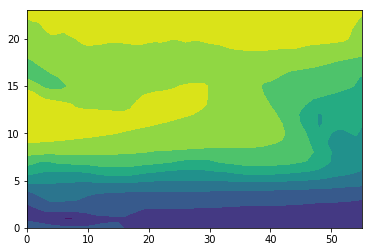

In [16]:
    print(t2m_exp.shape)
    ax = plt.contourf(t2m_exp[443,:,:])
    print(t2m_exp[443,:,:])
    print(month_exp[0,:,:].shape)

In [17]:
    x_input = np.stack((sic_exp_norm[1,:,:],
                        t2m_exp_norm[1,:,:],
                        ohc_exp_norm[1,:,:],
                        month_exp[1,:,:]))
    print(x_input[1,:,:])
    print(x_input[:].shape)

[[0.26267704 0.26046318 0.25661401 ... 0.22950646 0.22708498 0.22442972]
 [0.20302922 0.20179229 0.20073181 ... 0.23818486 0.23636252 0.23451899]
 [0.19524795 0.20810658 0.22415041 ... 0.25322432 0.25219251 0.25112267]
 ...
 [0.48474634 0.48954066 0.49081374 ... 0.36213768 0.336037   0.3028926 ]
 [0.49387301 0.5059012  0.52108218 ... 0.37193518 0.34423099 0.31239209]
 [0.52729484 0.54777388 0.5776589  ... 0.38700331 0.35481465 0.32946398]]
(4, 24, 56)


# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [10]:
    print ('*******************  parameter for check  *********************')
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 10
    hidden_channels = [10, 9, 1] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    #hidden_channels = [3, 3, 3, 3, 2]
    #hidden_channels = [2]
    kernel_size = 3
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    #num_layers = 1
    learning_rate = 0.005
    num_epochs = 1500
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    print ('*******************  cross validation and testing data  *********************')
    # take 10% data as cross-validation data
    cross_valid_year = 4
    # take 10% years as testing data
    test_year = 4
    # minibatch
    #iterations = 3 # training data divided into 3 sets

*******************  parameter for check  *********************
*******************  create basic dimensions for tensor and network  *********************
1.1.0
Is CUDA available? True
*******************  cross validation and testing data  *********************


In [13]:
    print ('*******************  preview of input tensor  *********************')
    #plt.plot(SIC_ERAI_sum)
    #print(SIC_ERAI_sum_norm[:-test_year*12])
    #print(x_input.shape)
    #print(x_input[:,:,:])
    sequence_len, _, _ = sic_exp_norm.shape
    print(sequence_len)

*******************  preview of input tensor  *********************
1824


In [ ]:
#     print ('*******************  module for calculating accuracy  *********************')
#     def accuracy(out, labels):
#         outputs = np.argmax(out, axis=1)
#     return np.sum(outputs==labels)/float(labels.size)

In [21]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    #model = torch.load(os.path.join(output_path, 'Barents','convlstm_era_sic_oras_ohc_Barents_hl_3_kernel_3_lr_0.005_epoch_1500.pkl'))
    model = torch.load(os.path.join(output_path, 'Barents','convlstm_era_sic_t2m_slp_z500_z850_uv10m_sflux_oras_ohc_Barents_hl_3_kernel_3_lr_0.005_epoch_1500_validSIC.pkl'))
    print(model)
     # check the sequence length (dimension in need for post-processing)
    sequence_len, height, width = sic_exp_norm.shape

*******************  load exsited LSTM model  *********************
ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (cell1): ConvLSTMCell(
    (Wxi): Conv2d(10, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(10, 9, kernel_size=(3, 

In [11]:
    %%time
    print ('*******************  run LSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # check the sequence length
    sequence_len, height, width = sic_exp_norm.shape

    # initialize our model
    model = deepclim.deepArray.ConvLSTM(input_channels, hidden_channels, kernel_size).cuda()
    loss_fn = torch.nn.MSELoss(size_average=True)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs)
    # loop of epoch
    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()
        # loop of timestep
        for timestep in range(sequence_len - cross_valid_year*12*4 - test_year*12*4):
            # hidden state re-initialized inside the model when timestep=0
            #################################################################################
            ########          create input tensor with multi-input dimension         ########
            #################################################################################
            # create variables
            x_input = np.stack((sic_exp_norm[timestep,:,:],
                                ohc_exp_norm[timestep,:,:],
                                t2m_exp_norm[timestep,:,:],
                                slp_exp_norm[timestep,:,:],
                                z500_exp_norm[timestep,:,:],
                                z850_exp_norm[timestep,:,:],
                                u10m_exp_norm[timestep,:,:],
                                v10m_exp_norm[timestep,:,:],
                                sflux_exp_norm[timestep,:,:],
                                month_exp[timestep,:,:])) #vstack,hstack,dstack
            x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).cuda()
            #################################################################################
            ########       create training tensor with multi-input dimension         ########
            #################################################################################
            y_train_stack = sic_exp_norm[timestep+1,:,:] #vstack,hstack,dstack
            y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).cuda()
            #################################################################################   
            # Forward pass
            y_pred, _ = model(x_var, timestep)
            # choose training data
            y_train = y_var        
            # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
            # Please Make Sure y_pred & y_train have the same dimension
            # accumulate loss
            if timestep == 0:
                loss = loss_fn(y_pred, y_train)
            else:
                loss += loss_fn(y_pred, y_train)
            #print (timestep)
        #print(y_pred.shape)
        #print(y_train.shape)
        # print loss at certain iteration
        if t % 5 == 0:
            print("Epoch ", t, "MSE: ", loss.item())
            #print(y_pred)
            # gradient check
            # Gradcheck requires double precision numbers to run
            #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
            #print(res)
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
    torch.save(model, os.path.join(output_path,'convlstm.pkl')) # save lstm model

*******************  run LSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.


G:\Anaconda\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (cell1): ConvLSTMCell(
    (Wxi): Conv2d(10, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(10, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(9, 9, kernel_si

In [22]:
    print ('*******************  evaluation matrix  *********************')
    # The prediction will be evaluated through RMSE against climatology
    def RMSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        """
        rmse = np.sqrt(np.mean((x-y)**2,0))
    
        return rmse
    
    def RSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        """
        rmse = np.sqrt((x-y)**2)
    
        return rmse

*******************  evaluation matrix  *********************


In [23]:
    %%time
    #################################################################################
    ########       lead time depedent prediction for cross-validation        ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    print ('************  the last {} years of total time series are treated as test data  ************'.format(cross_valid_year))
    # time series before test data
    pred_base_sic = sic_exp_norm[-cross_valid_year*12*4-test_year*12*4:-test_year*12*4,:,:]
    # predict x steps ahead
    step_lead = 6 # unit week
    # create a matrix for the prediction
    lead_pred_sic = np.zeros((cross_valid_year*12*4,step_lead,height,width),dtype=float) # dim [predict time, lead time, lat, lon]
    # start the prediction loop
    for step in range(cross_valid_year*12*4):
        # Clear stored gradient
        model.zero_grad()
        # Don't do this if you want your LSTM to be stateful
        # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
        # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
        # model.hidden = model.init_hidden()
        # based on the design of this module, the hidden states and cell states are initialized when the module is called.
        for i in np.arange(1,sequence_len-cross_valid_year*12*4-test_year*12*4 + step + step_lead,1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
            #############################################################################
            ###############           before time of prediction           ###############
            #############################################################################
            if i <= (sequence_len-cross_valid_year*12*4-test_year*12*4 + step):
                # create variables
                x_input = np.stack((sic_exp_norm[i-1,:,:],
                                    ohc_exp_norm[i-1,:,:],
                                    t2m_exp_norm[i-1,:,:],
                                    slp_exp_norm[i-1,:,:],
                                    z500_exp_norm[i-1,:,:],
                                    z850_exp_norm[i-1,:,:],
                                    u10m_exp_norm[i-1,:,:],
                                    v10m_exp_norm[i-1,:,:],
                                    sflux_exp_norm[i-1,:,:],                                    
                                    month_exp[i-1,:,:])) #vstack,hstack,dstack
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False).cuda()
                # make prediction
                last_pred, _ = model(x_var_pred, i-1)
                # record the real prediction after the time of prediction
                if i == (sequence_len-cross_valid_year*12*4-test_year*12*4 + step):
                    lead = 0
                    # GPU data should be transferred to CPU
                    lead_pred_sic[step,0,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
            #############################################################################
            ###############            after time of prediction           ###############
            #############################################################################
            else:
                lead += 1
                # prepare predictor
                # use the predicted data to make new prediction
                x_input = np.stack((lead_pred_sic[step,i-(sequence_len-cross_valid_year*12*4-test_year*12*4 + step +1),:,:],
                                    ohc_exp_norm[i-1,:,:],
                                    t2m_exp_norm[i-1,:,:],
                                    slp_exp_norm[i-1,:,:],
                                    z500_exp_norm[i-1,:,:],
                                    z850_exp_norm[i-1,:,:],
                                    u10m_exp_norm[i-1,:,:],
                                    v10m_exp_norm[i-1,:,:],
                                    sflux_exp_norm[i-1,:,:],
                                    month_exp[i-1,:,:])) #vstack,hstack,dstack
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False).cuda()        
                # make prediction
                last_pred, _ = model(x_var_pred, i-1)
                # record the prediction
                lead_pred_sic[step,lead,:,:] = last_pred[0,0,:,:].cpu().data.numpy()

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
************  the last 4 years of total time series are treated as test data  ************
Wall time: 30min 31s


*******************  Predicted Ice Extent  **********************


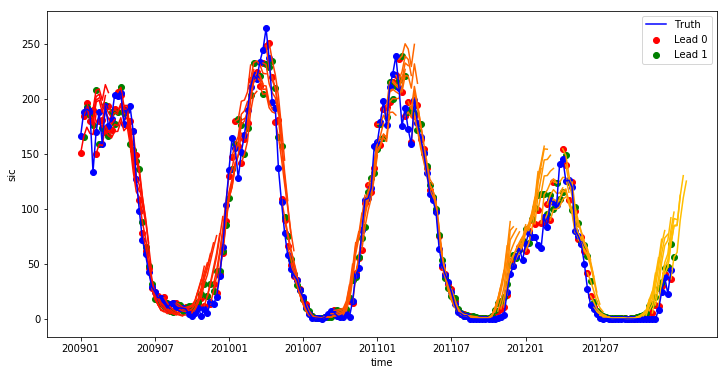

*******************  Loss with time  **********************
*******************  Prediction Ice Distribution  **********************
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


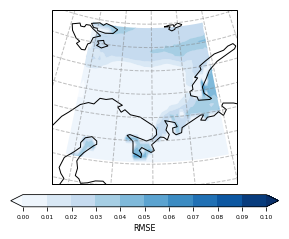

*******************  Other variables (Prediction with testing sets only) **********************


In [24]:
    #############################################################################################################
    ########        visualization of lead time dependent prediction with cross-validation data           ########
    #############################################################################################################
    index_plot = np.arange(cross_valid_year*12*4)
    index_plot_step = np.arange(cross_valid_year*12*4+1)
    year_index = np.arange(2009,2013,1)
    # repeat climatology as reference
    #climatology = np.tile(seansonal_cycle_SIC,len(year_ERAI))
    # create index
    # correction for float point at 0
    lead_pred_sic[lead_pred_sic<0] = 0    
    print ("*******************  Predicted Ice Extent  **********************")
    # include text box in the figure
    #text_content = '$RMSE=%.3f$ ' % (error_pred)
    sic_extend_lead = np.sum(np.sum(lead_pred_sic,3),2)
    colormap=cm.autumn(range(cross_valid_year*12*4))
    
    fig0 = plt.figure(figsize=(12,6))
    for i in range(cross_valid_year*12*4):
        plt.plot(np.arange(index_plot[i],index_plot[i]+step_lead), sic_extend_lead[i,:], color=colormap[i])
    plt.scatter(index_plot, sic_extend_lead[:,0], color='r', label="Lead 0")
    plt.scatter(index_plot_step[1:], sic_extend_lead[:,1], color='g', label="Lead 1")
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-cross_valid_year*12*4-test_year*12*4:-test_year*12*4,:,:],2),1), 'b', label="Truth")
    plt.scatter(index_plot, np.sum(np.sum(sic_exp_norm[-cross_valid_year*12*4-test_year*12*4:-test_year*12*4,:,:],2),1),color='b')
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    plt.xlabel('time')
    plt.ylabel('sic')
    plt.xticks(np.arange(0,cross_valid_year*12*4,6*4),(['200901', '200907', '201001', '201007',
                                                        '201101', '201107', '201201', '201207']))
    plt.legend(loc=1)
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    #ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig0.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_lead_crossValid.png'),dpi=300)
    
    print ("*******************  Loss with time  **********************")
    
    print ("*******************  Prediction Ice Distribution  **********************")
    rmse_spatial = np.mean(RSE(lead_pred_sic[:,0,:,:],
                               sic_exp_norm[-cross_valid_year*12*4-test_year*12*4:-test_year*12*4,:,:]),0)
    label = 'RMSE'
    ticks = [i for i in np.linspace(0,0.1,11)]
    p = None # no t-test
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   rmse_spatial, p, # np.ma.masked_where(mask,data_predict_sic[0,:,:])
                                   label, ticks, os.path.join(output_path,
                                   'spatial_sic_rmse_avg_crossValid.png'), boundary='Barents_Polar',
                                   colormap='Blues')
    print ("*******************  Other variables (Prediction with testing sets only) **********************")

In [26]:
    %%time
    #################################################################################
    ########  operational lead time dependent prediction with testing data   ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    print ('************  the last {} years of total time series are treated as test data  ************'.format(test_year))
    # time series before test data
    pred_base_sic = sic_exp_norm[:-test_year*12*4,:,:]
    # predict x steps ahead
    step_lead = 6 # unit week
    # create a matrix for the prediction
    lead_pred_sic = np.zeros((test_year*12*4,step_lead,height,width),dtype=float) # dim [predict time, lead time, lat, lon]
    # start the prediction loop
    for step in range(test_year*12*4):
        # Clear stored gradient
        model.zero_grad()
        # Don't do this if you want your LSTM to be stateful
        # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
        # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
        # model.hidden = model.init_hidden()
        # based on the design of this module, the hidden states and cell states are initialized when the module is called.
        for i in np.arange(1,sequence_len-test_year*12*4 + step + step_lead,1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
            #############################################################################
            ###############           before time of prediction           ###############
            #############################################################################
            if i <= (sequence_len-test_year*12*4 + step):
                # create variables
                x_input = np.stack((sic_exp_norm[i-1,:,:],
                                    ohc_exp_norm[i-1,:,:],
                                    t2m_exp_norm[i-1,:,:],
                                    slp_exp_norm[i-1,:,:],
                                    z500_exp_norm[i-1,:,:],
                                    z850_exp_norm[i-1,:,:],
                                    u10m_exp_norm[i-1,:,:],
                                    v10m_exp_norm[i-1,:,:],
                                    sflux_exp_norm[i-1,:,:],
                                    month_exp[i-1,:,:])) #vstack,hstack,dstack
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False).cuda()
                # make prediction
                last_pred, _ = model(x_var_pred, i-1)
                # record the real prediction after the time of prediction
                if i == (sequence_len-test_year*12*4 + step):
                    lead = 0
                    # GPU data should be transferred to CPU
                    lead_pred_sic[step,0,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
            #############################################################################
            ###############            after time of prediction           ###############
            #############################################################################
            else:
                lead += 1
                # prepare predictor
                if i <= sequence_len:
                    # use the predicted data to make new prediction
                    x_input = np.stack((lead_pred_sic[step,i-(sequence_len-test_year*12*4 + step +1),:,:],
                                        ohc_exp_norm[i-1,:,:],
                                        t2m_exp_norm[i-1,:,:],
                                        slp_exp_norm[i-1,:,:],
                                        z500_exp_norm[i-1,:,:],
                                        z850_exp_norm[i-1,:,:],
                                        u10m_exp_norm[i-1,:,:],
                                        v10m_exp_norm[i-1,:,:],
                                        sflux_exp_norm[i-1,:,:],
                                        month_exp[i-1,:,:])) #vstack,hstack,dstack
                else: # choice_exp_norm out of range, use the last value
                    x_input = np.stack((lead_pred_sic[step,i-(sequence_len-test_year*12*4 + step +1),:,:],
                                        ohc_exp_norm[-1,:,:],
                                        t2m_exp_norm[-1,:,:],
                                        slp_exp_norm[-1,:,:],
                                        z500_exp_norm[-1,:,:],
                                        z850_exp_norm[-1,:,:],
                                        u10m_exp_norm[-1,:,:],
                                        v10m_exp_norm[-1,:,:],
                                        sflux_exp_norm[-1,:,:],
                                        month_exp[i-1,:,:])) #vstack,hstack,dstack                    
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False).cuda()        
                # make prediction
                last_pred, _ = model(x_var_pred, i-1)
                # record the prediction
                lead_pred_sic[step,lead,:,:] = last_pred[0,0,:,:].cpu().data.numpy()

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
************  the last 4 years of total time series are treated as test data  ************
Wall time: 34min 11s


In [25]:
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)

*******************  Predicted Ice Extent  **********************


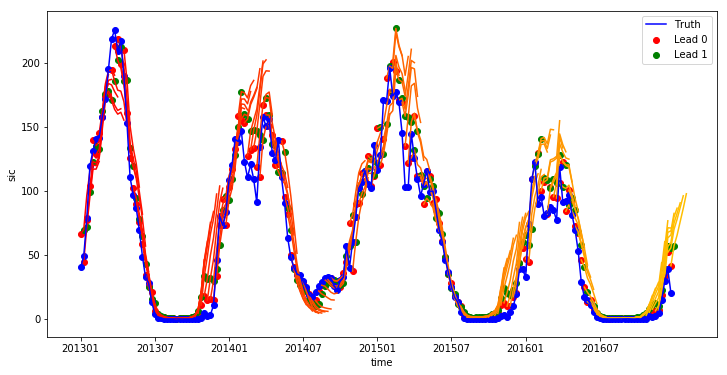

*******************  Prediction Ice Distribution  **********************
###   RMSE for all months during testing period   ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


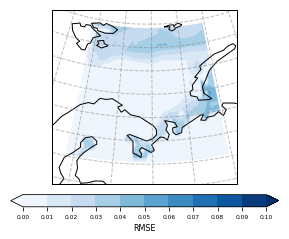

###   Difference of RMSE for all months during testing period for predictions and persistence  ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


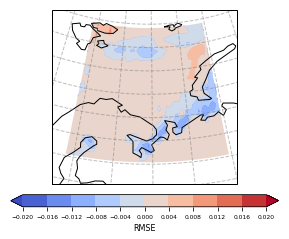

###   RMSE for each month during testing period   ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


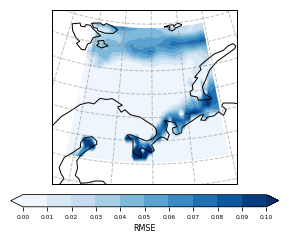

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


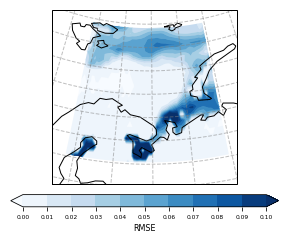

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


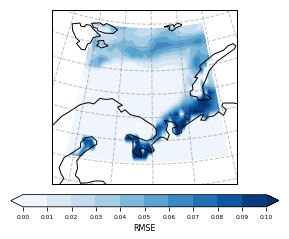

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


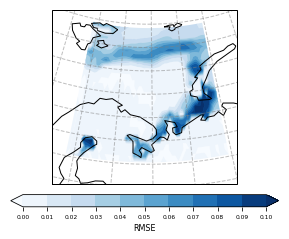

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


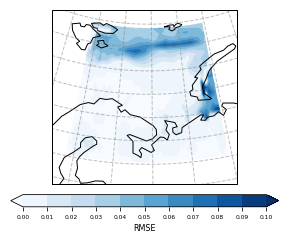

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


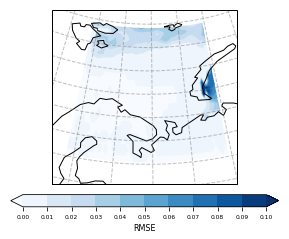

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


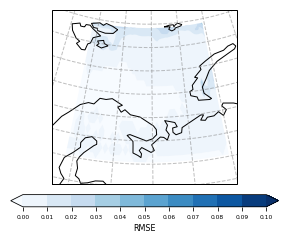

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


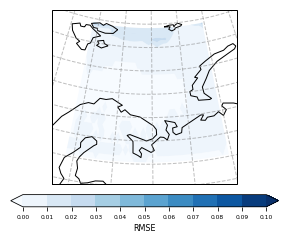

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


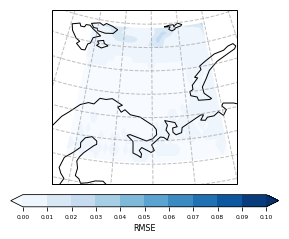

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


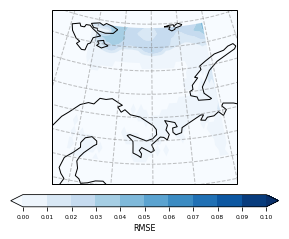

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


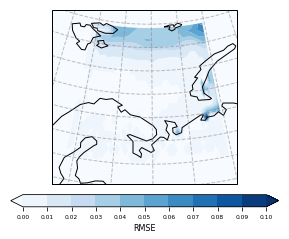

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


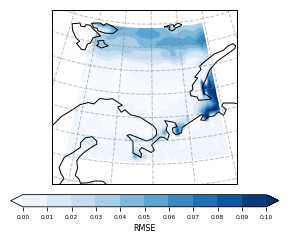

###   Difference of RMSE for each month during testing period and persistence  ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


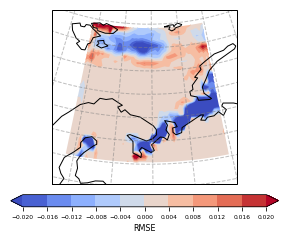

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


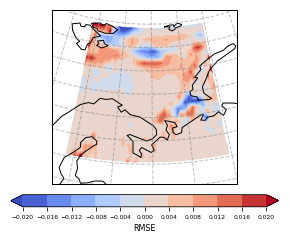

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


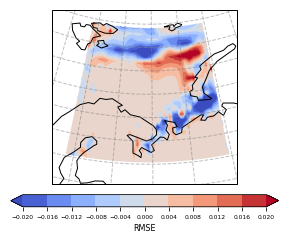

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


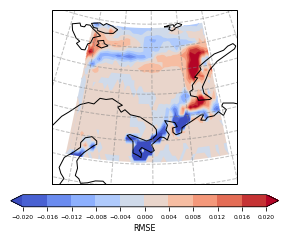

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


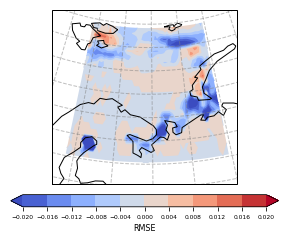

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


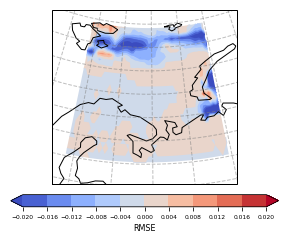

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


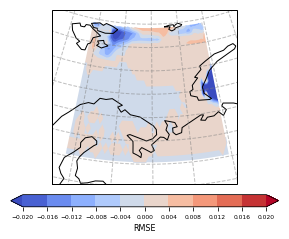

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


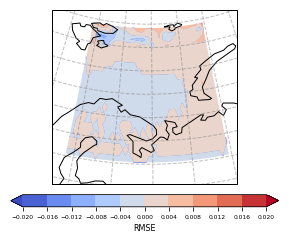

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


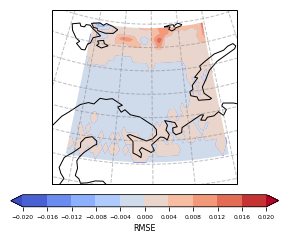

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


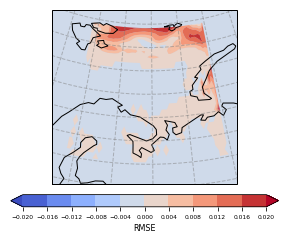

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


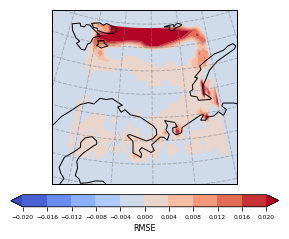

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


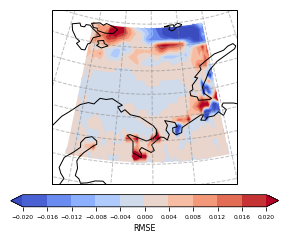

*******************  histrogram of the values **********************


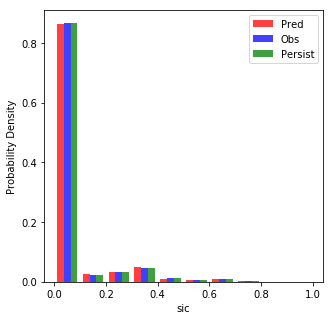

*******************  scatter obs data v.s. testing data **********************


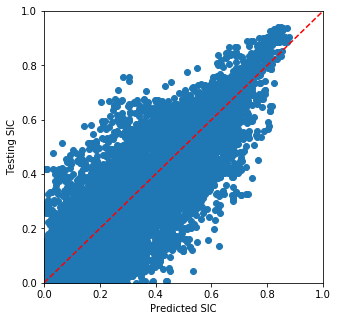

*******************  quantile mapping obs data v.s. testing data **********************


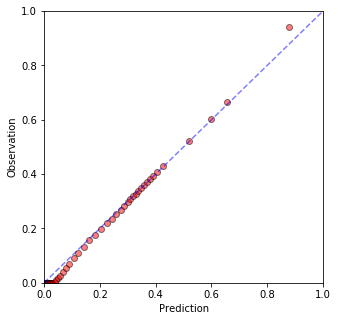

In [43]:
    #################################################################################
    ########        visualization of lead time dependent predictio           ########
    #################################################################################
    index_plot = np.arange(test_year*12*4)
    index_plot_step = np.arange(test_year*12*4+1)
    year_index = np.arange(2013,2017,1)
    # repeat climatology as reference
    #climatology = np.tile(seansonal_cycle_SIC,len(year_ERAI))
    # create index
    # correction for float point at 0
    lead_pred_sic[lead_pred_sic<0] = 0    
    print ("*******************  Predicted Ice Extent  **********************")
    # include text box in the figure
    #text_content = '$RMSE=%.3f$ ' % (error_pred)
    sic_extend_lead = np.sum(np.sum(lead_pred_sic,3),2)
    colormap=cm.autumn(range(test_year*12*4))
    
    fig0 = plt.figure(figsize=(12,6))
    for i in range(test_year*12*4):
        plt.plot(np.arange(index_plot[i],index_plot[i]+step_lead), sic_extend_lead[i,:], color=colormap[i])
    plt.scatter(index_plot, sic_extend_lead[:,0], color='r', label="Lead 0")
    plt.scatter(index_plot_step[1:], sic_extend_lead[:,1], color='g', label="Lead 1")
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1), 'b', label="Truth")
    plt.scatter(index_plot,np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1),color='b')
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    plt.xlabel('time')
    plt.ylabel('sic')
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201301', '201307', '201401', '201407',
                                                 '201501', '201507', '201601', '201607']))
    plt.legend(loc=1)
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    #ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig0.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_lead_test.png'),dpi=200)
    
    print ("*******************  Prediction Ice Distribution  **********************")
    rse_spatial = RSE(lead_pred_sic[:,0,:,:],sic_exp_norm[-test_year*12*4:,:,:])   
    print("###   RMSE for all months during testing period   ###")
    label = 'RMSE'
    ticks = [i for i in np.linspace(0,0.1,11)]
    p = None # no t-test
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   np.mean(rse_spatial,0), p, # np.ma.masked_where(mask,data_predict_sic[0,:,:])
                                   label, ticks, os.path.join(output_path,
                                   'spatial_sic_rmse_avg_test.png'), boundary='Barents_Polar',
                                   colormap='Blues')
    
    rse_persist = RSE(sic_exp_norm[-test_year*12*4-1:-1,:,:],sic_exp_norm[-test_year*12*4:,:,:])
    print("###   Difference of RMSE for all months during testing period for predictions and persistence  ###")
    label = 'RMSE'
    ticks = [i for i in np.linspace(-0.02,0.02,11)]
    p = None # no t-test
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   np.mean(rse_spatial - rse_persist,0), p, # np.ma.masked_where(mask,data_predict_sic[0,:,:])
                                   label, ticks, os.path.join(output_path,
                                   'spatial_sic_rmse_avg_test-persist.png'), boundary='Barents_Polar',
                                   colormap='coolwarm')      
    
    print("###   RMSE for each month during testing period   ###")
    ticks = [i for i in np.linspace(0,0.1,11)]
    for i in np.arange(1,13,1):
        # 48 weeks in total
        rse_spatial_monthly = np.mean((rse_spatial[(i-1)*4::48,:,:] + rse_spatial[(i-1)*4+1::48,:,:] +
                                       rse_spatial[(i-1)*4+2::48,:,:] + rse_spatial[(i-1)*4+3::48,:,:]) / 4.0, 0)
        deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                       rse_spatial_monthly, p, label, ticks,
                                       os.path.join(output_path,
                                       'spatial_sic_rmse_avg_test_month_{}.png'.format(i)), boundary='Barents_Polar',
                                       colormap='Blues')
    
    print("###   Difference of RMSE for each month during testing period and persistence  ###")
    ticks = [i for i in np.linspace(-0.02,0.02,11)]
    for i in np.arange(1,13,1):
        # 48 weeks in total
        rse_spatial_monthly = np.mean((rse_spatial[(i-1)*4::48,:,:] + rse_spatial[(i-1)*4+1::48,:,:] +
                                       rse_spatial[(i-1)*4+2::48,:,:] + rse_spatial[(i-1)*4+3::48,:,:] -
                                       rse_persist[(i-1)*4::48,:,:] - rse_persist[(i-1)*4+1::48,:,:] -
                                       rse_persist[(i-1)*4+2::48,:,:] - rse_persist[(i-1)*4+3::48,:,:] ) / 4.0, 0)
        deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                       rse_spatial_monthly, p, label, ticks,
                                       os.path.join(output_path,
                                       'spatial_sic_rmse_avg_test-persist_month_{}.png'.format(i)), boundary='Barents_Polar',
                                       colormap='coolwarm')
    
    print ("*******************  histrogram of the values **********************")
    fig3 = plt.figure(figsize=(5,5))
    # make the probability density sum to be 1
    weights_pred = np.ones_like(lead_pred_sic[:,0,:,:].flatten())/float(len(lead_pred_sic[:,0,:,:].flatten()))
    weights_obs = np.ones_like(sic_exp_norm[-test_year*12*4:,:,:].flatten())/float(len(sic_exp_norm[-test_year*12*4:,:,:].flatten()))
    weight_persist = np.ones_like(sic_exp_norm[-test_year*12*4-1:-1,:,:].flatten())/float(len(sic_exp_norm[-test_year*12*4-1:-1,:,:].flatten()))
    plt.hist(np.vstack((lead_pred_sic[:,0,:,:].flatten(),
                        sic_exp_norm[-test_year*12*4:,:,:].flatten(),
                        sic_exp_norm[-test_year*12*4-1:-1,:,:].flatten())).T,
             bins=10, range=(0.0,1.0), weights=np.vstack((weights_pred,weights_obs,weight_persist)).T,
             density=False, color=['r','b','g'], alpha=0.75, label=['Pred','Obs','Persist'])
    plt.xlabel('sic')
    plt.ylabel('Probability Density')
    axes = plt.gca()
    #axes.set_ylim(0,0.9)
    plt.legend()
    plt.show()
    fig3.savefig(os.path.join(output_path,'sic_ERAI_LSTM_pred_lead_test_hist.png'),dpi=200)
    
    print ("*******************  scatter obs data v.s. testing data **********************")
    fig4 = plt.figure(figsize=(5,5))
    plt.scatter(np.sort(lead_pred_sic[:,0,:,:]), np.sort(sic_exp_norm[-test_year*12*4:,:,:]))
    plt.xlabel('Predicted SIC')
    plt.ylabel('Testing SIC')
    axes = plt.gca()
    axes.set_xlim(0,1.0)
    axes.set_ylim(0,1.0)
    axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c="r")
    #plt.plot(np.arange(0,1.0,11),np.arange(0,1.0,11),'r')
    #plt.legend()
    plt.show()
    fig4.savefig(os.path.join(output_path,'sic_ERAI_LSTM_pred_lead_test_scatter.png'),dpi=200)
    
    print ("*******************  quantile mapping obs data v.s. testing data **********************")
    # Draw quantile-quantile plot
    plt.figure(figsize=(5,5))
    qqplot(np.sort(lead_pred_sic[:,0,:,:]), np.sort(sic_exp_norm[-test_year*12*4:,:,:]),
           c='r', alpha=0.5, edgecolor='k')
    plt.xlabel('Prediction')
    plt.ylabel('Observation')
    axes = plt.gca()
    axes.set_xlim(0,1.0)
    axes.set_ylim(0,1.0)
    axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c="b", alpha=0.5)
    #plt.title('Quantile Mapping')
    plt.savefig(os.path.join(output_path,'sic_ERAI_LSTM_pred_lead_test_quantile.png'),dpi=200)
    plt.show()
    plt.close()

In [32]:
    #################################################################################
    ########           performance evaluation with other methods             ########
    #################################################################################
    sequence_len, height, width = sic_exp_norm.shape
    print('##############################################################')
    print('############   start prediction with climatology  ############')
    print('##############################################################')
    # compute climatology
    climatology = np.zeros((48, height, width),dtype=float)
    for i in range(48):
        climatology[i,:,:] = np.mean(sic_exp_norm[i::48,:,:],axis=0)
    # repeat this climatology and calculate the RMSE
    climatology_seq = np.tile(climatology,(test_year,1,1))
    RMSE_climatology = np.sum(RMSE(climatology_seq,sic_exp_norm[-test_year*12*4:,:,:]))
    print('##############################################################')
    print('############   start prediction with persistence  ############')
    print('##############################################################')
    RMSE_persist_0 = RMSE(sic_exp_norm[-test_year*12*4-1:-1,:,:],sic_exp_norm[-test_year*12*4:,:,:])
    RMSE_persist_1 = RMSE(sic_exp_norm[-test_year*12*4-1:-2,:,:],sic_exp_norm[-test_year*12*4+1:,:,:])
    RMSE_persist_2 = RMSE(sic_exp_norm[-test_year*12*4-1:-3,:,:],sic_exp_norm[-test_year*12*4+2:,:,:])
    RMSE_persist_3 = RMSE(sic_exp_norm[-test_year*12*4-1:-4,:,:],sic_exp_norm[-test_year*12*4+3:,:,:])
    RMSE_persist_4 = RMSE(sic_exp_norm[-test_year*12*4-1:-5,:,:],sic_exp_norm[-test_year*12*4+4:,:,:])
    RMSE_persist_5 = RMSE(sic_exp_norm[-test_year*12*4-1:-6,:,:],sic_exp_norm[-test_year*12*4+5:,:,:])
    print('##############################################################')
    print('########   start prediction with linear regression   #########')
    print('##############################################################')
    
    print('#################################################################################')
    print('############   evaluation and statistical matrix for the entire year ############')
    print('#################################################################################')
    RMSE_ConvLSTM_0 = RMSE(lead_pred_sic[:,0,:,:],sic_exp_norm[-test_year*12*4:,:,:])
    RMSE_ConvLSTM_1 = RMSE(lead_pred_sic[:-1,1,:,:],sic_exp_norm[-test_year*12*4+1:,:,:])
    RMSE_ConvLSTM_2 = RMSE(lead_pred_sic[:-2,2,:,:],sic_exp_norm[-test_year*12*4+2:,:,:])
    RMSE_ConvLSTM_3 = RMSE(lead_pred_sic[:-3,3,:,:],sic_exp_norm[-test_year*12*4+3:,:,:])
    RMSE_ConvLSTM_4 = RMSE(lead_pred_sic[:-4,4,:,:],sic_exp_norm[-test_year*12*4+4:,:,:])
    RMSE_ConvLSTM_5 = RMSE(lead_pred_sic[:-5,5,:,:],sic_exp_norm[-test_year*12*4+5:,:,:])
    print("*******************     Lead time 0     *******************")
    print("Total RMSE with testing data - ConvLSTM")
    print(np.sum(RMSE_ConvLSTM_0))
    print("Total RMSE with testing data - Climatology")
    print(RMSE_climatology)
    print("Total RMSE with testing data - Persistence")
    print(np.sum(RMSE_persist_0))
    print("*******************     Lead time 1     *******************")
    print("Total RMSE with testing data - ConvLSTM")
    print(np.sum(RMSE_ConvLSTM_1))
    print("Total RMSE with testing data - Persistence")
    print(np.sum(RMSE_persist_1))
    print("*******************     Lead time 2     *******************")
    print("Total RMSE with testing data - ConvLSTM")
    print(np.sum(RMSE_ConvLSTM_2))
    print("Total RMSE with testing data - Persistence")
    print(np.sum(RMSE_persist_2))
    print("*******************     Lead time 3     *******************")
    print("Total RMSE with testing data - ConvLSTM")
    print(np.sum(RMSE_ConvLSTM_3))
    print("Total RMSE with testing data - Persistence")
    print(np.sum(RMSE_persist_3))
    print("*******************     Lead time 4     *******************")
    print("Total RMSE with testing data - ConvLSTM")
    print(np.sum(RMSE_ConvLSTM_4))
    print("Total RMSE with testing data - Persistence")
    print(np.sum(RMSE_persist_4))
    print("*******************     Lead time 5     *******************")
    print("Total RMSE with testing data - ConvLSTM")
    print(np.sum(RMSE_ConvLSTM_5))
    print("Total RMSE with testing data - Persistence")
    print(np.sum(RMSE_persist_5))
    print('##############################################################')
    print('############           create a txt file          ############')
    print('##############################################################')
    f = open(os.path.join(output_path,"report_rmse_pred.txt"),"w+")
    f.write("############   evaluation of prediction   ############\n")
    f.write("############   Total RMSE with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    f.write("RMSE - ConvLSTM       {}\n".format(np.sum(RMSE_ConvLSTM_0)))
    f.write("RMSE - Climatology    {}\n".format(RMSE_climatology))
    f.write("RMSE - Persistence    {}\n".format(np.sum(RMSE_persist_0)))
    f.write("*******************     Lead time 1     *******************\n")
    f.write("RMSE - ConvLSTM       {}\n".format(np.sum(RMSE_ConvLSTM_1)))
    f.write("RMSE - Persistence    {}\n".format(np.sum(RMSE_persist_1)))
    f.write("*******************     Lead time 2     *******************\n")
    f.write("RMSE - ConvLSTM       {}\n".format(np.sum(RMSE_ConvLSTM_2)))
    f.write("RMSE - Persistence    {}\n".format(np.sum(RMSE_persist_2)))
    f.write("*******************     Lead time 3     *******************\n")
    f.write("RMSE - ConvLSTM       {}\n".format(np.sum(RMSE_ConvLSTM_3)))
    f.write("RMSE - Persistence    {}\n".format(np.sum(RMSE_persist_3)))
    f.write("*******************     Lead time 4     *******************\n")
    f.write("RMSE - ConvLSTM       {}\n".format(np.sum(RMSE_ConvLSTM_4)))
    f.write("RMSE - Persistence    {}\n".format(np.sum(RMSE_persist_4)))
    f.write("*******************     Lead time 5     *******************\n")
    f.write("RMSE - ConvLSTM       {}\n".format(np.sum(RMSE_ConvLSTM_5)))
    f.write("RMSE - Persistence    {}\n".format(np.sum(RMSE_persist_5)))
    f.write("-\n")
    f.write("-\n")
    f.write("-\n")
    f.write("############   Monthly RMSE with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    for i in np.arange(1,13,1):
        ConvLSTM_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        persist_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        climatology_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        truth_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        for j in np.arange(4):
            ConvLSTM_monthly_series[j::4,:,:] = lead_pred_sic[(i-1)*4+j::48,0,:,:]
            persist_monthly_series[j::4,:,:] = sic_exp_norm[-test_year*12*4-1+(i-1)*4+j:-1:48,:,:]
            climatology_monthly_series[j::4,:,:] = climatology_seq[(i-1)*4+j::48,:,:]
            truth_monthly_series[j::4,:,:] = sic_exp_norm[-test_year*12*4+(i-1)*4+j::48,:,:]
        print("*******************    {}     *******************".format(i))
        print("RMSE - ConvLSTM       {}".format(np.sum(RMSE(ConvLSTM_monthly_series,truth_monthly_series))))
        print("RMSE - Climatology    {}".format(np.sum(RMSE(climatology_monthly_series,truth_monthly_series))))
        print("RMSE - Persistence    {}".format(np.sum(RMSE(persist_monthly_series,truth_monthly_series))))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("RMSE - ConvLSTM       {}\n".format(np.sum(RMSE(ConvLSTM_monthly_series,truth_monthly_series))))
        f.write("RMSE - Climatology    {}\n".format(np.sum(RMSE(climatology_monthly_series,truth_monthly_series))))
        f.write("RMSE - Persistence    {}\n".format(np.sum(RMSE(persist_monthly_series,truth_monthly_series))))
        
    f.write("*******************     Lead time 6     *******************\n")
    f.close()

##############################################################
############   start prediction with climatology  ############
##############################################################
##############################################################
############   start prediction with persistence  ############
##############################################################
##############################################################
########   start prediction with linear regression   #########
##############################################################
#################################################################################
############   evaluation and statistical matrix for the entire year ############
#################################################################################
*******************     Lead time 0     *******************
Total RMSE with testing data - ConvLSTM
29.43783384428906
Total RMSE with testing data - Climatology
89.01967588316143
Total RM

In [33]:
    print ('*******************  module for calculating accuracy/recall/precision  *********************')
    def accuracy(pred, label):
        #print("Input size must be [seq, lat, lon]")
        seq, lat, lon = pred.shape
        boolean = (pred==label)
        accu_seq = np.mean(np.mean(boolean.astype(float),2),1)
        accu_spa = np.mean(boolean.astype(float),0)
        
        return accu_seq, accu_spa

*******************  module for calculating accuracy/recall/precision  *********************


In [34]:
    #################################################################################
    ########          transfer the sea ice fields into binary data           ########
    #################################################################################
    criterion_0 = 0.15 # ice concentration below the threshold is regarded as no ice
    # remove the area weight
    sic_exp_denorm = np.zeros(sic_exp_norm.shape, dtype=float)
    lead_pred_sic_denorm = np.zeros(lead_pred_sic.shape, dtype=float)
    for i in np.arange(height):
        lead_pred_sic_denorm[:,:,i,:] = lead_pred_sic[:,:,i,:] /dx[i+12] * dx[35]
        sic_exp_denorm[:,i,:] = sic_exp_norm[:,i,:] / dx[i+12] * dx[35]
    # turn sea ice fields into binary data
    lead_pred_sic_bin = lead_pred_sic_denorm[:]
    sic_exp_bin = sic_exp_denorm[:]
    lead_pred_sic_bin[lead_pred_sic_bin <= criterion_0] = 0
    lead_pred_sic_bin[lead_pred_sic_bin > criterion_0] = 1
    sic_exp_bin[sic_exp_bin <= criterion_0] = 0
    sic_exp_bin[sic_exp_bin > criterion_0] = 1
    # turn matrix into int
    lead_pred_sic_bin = lead_pred_sic_bin.astype(int)
    sic_exp_bin = sic_exp_bin.astype(int)

*******************  Predicted Ice Extent  **********************


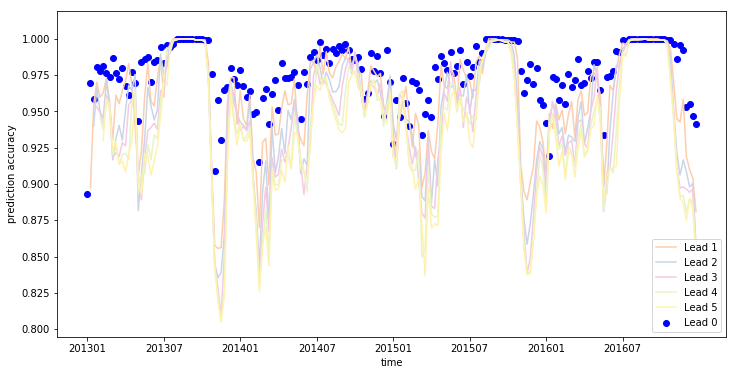

*******************  Prediction Ice Distribution  **********************
###   Prediction accuracy for all months during testing period   ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


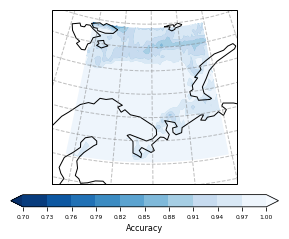

###   Difference between prediction accuracy for all months during testing period and persistence  ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


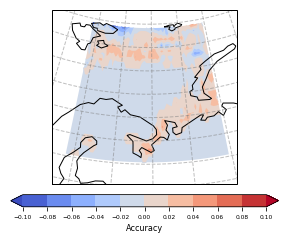

###   Prediction accuracy for each month during testing period   ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


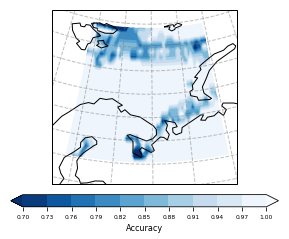

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


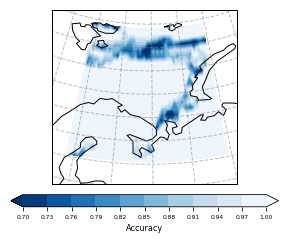

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


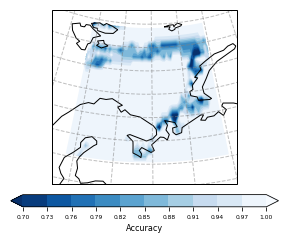

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


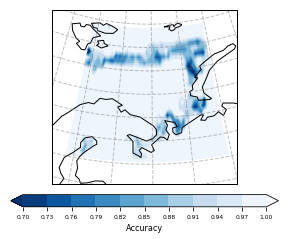

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


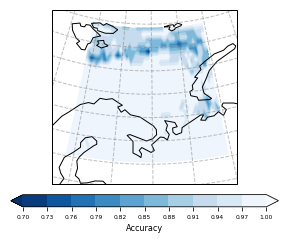

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


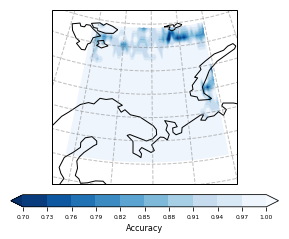

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


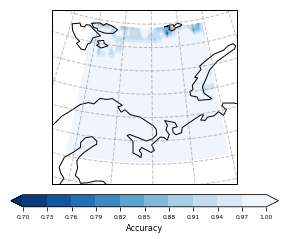

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


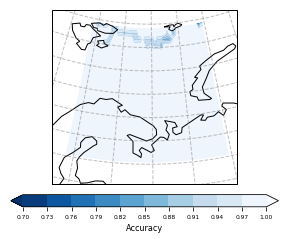

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


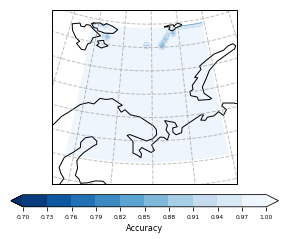

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


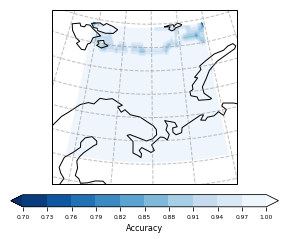

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


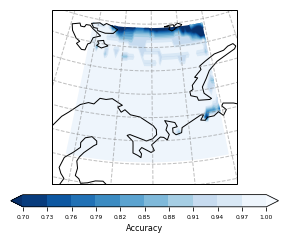

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


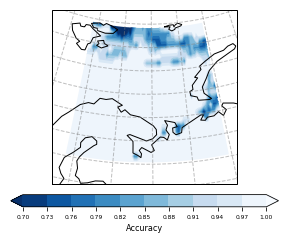

###   Prediction accuracy for each month during testing period and the difference between persistence  ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


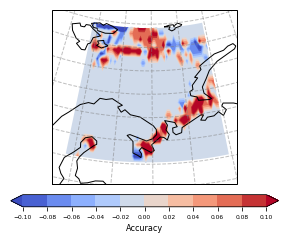

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


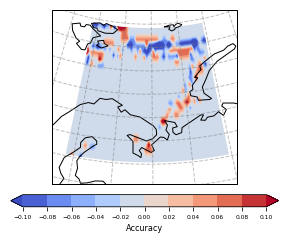

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


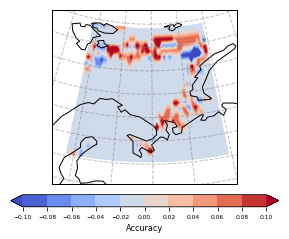

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


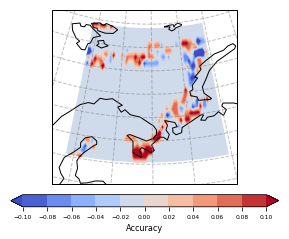

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


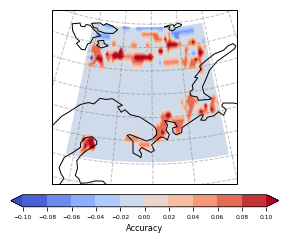

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


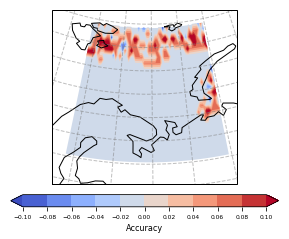

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


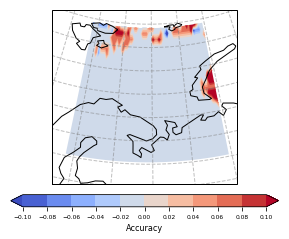

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


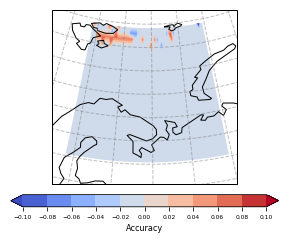

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


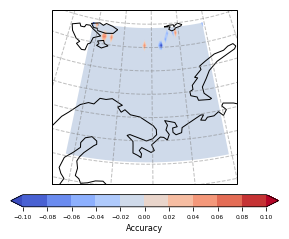

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


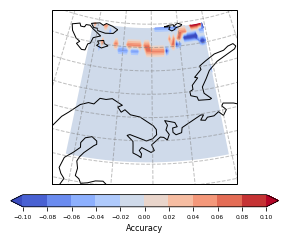

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


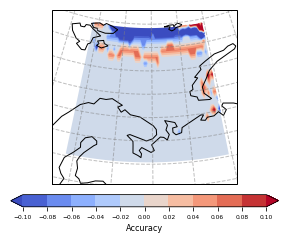

Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


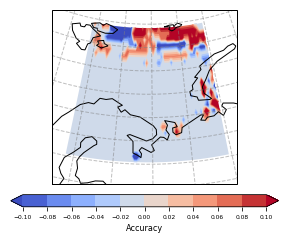

In [35]:
    #################################################################################
    ########        visualization of lead time dependent prediction          ########
    #################################################################################
    index_plot = np.arange(test_year*12*4)
    index_plot_step = np.arange(test_year*12*4+1)
    year_index = np.arange(2013,2017,1)
    # repeat climatology as reference
    #climatology = np.tile(seansonal_cycle_SIC,len(year_ERAI))
    
    print ("*******************  Predicted Ice Extent  **********************")
    # include text box in the figure
    #text_content = '$RMSE=%.3f$ ' % (error_pred)
    colormap=cm.Pastel2(np.arange(step_lead))
    
    fig0 = plt.figure(figsize=(12,6))
    for i in np.arange(step_lead):
        if i == 0:
            accu_seq, _ = accuracy(lead_pred_sic_bin[:,i,:,:], sic_exp_bin[-test_year*12*4:,:,:])
            plt.scatter(index_plot, accu_seq, color='b', label="Lead 0")
        else:
            accu_seq, _ = accuracy(lead_pred_sic_bin[:-i,i,:,:], sic_exp_bin[-test_year*12*4+i:,:,:])
            plt.plot(index_plot[i:], accu_seq, color=colormap[i], label="Lead {}".format(i))

    plt.xlabel('time')
    plt.ylabel('prediction accuracy')
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201301', '201307', '201401', '201407',
                                                 '201501', '201507', '201601', '201607']))
    plt.legend(loc=4)
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    #ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig0.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_lead_test_bin.png'),dpi=200) 
    
    print ("*******************  Prediction Ice Distribution  **********************")
    accu_seq , accu_spa = accuracy(lead_pred_sic_bin[:,0,:,:], sic_exp_bin[-test_year*12*4:,:,:])
    
    print("###   Prediction accuracy for all months during testing period   ###")
    label = 'Accuracy'
    ticks = [i for i in np.linspace(0.7,1.0,11)]
    p = None # no t-test
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   accu_spa, p, label, ticks,
                                   os.path.join(output_path,
                                   'spatial_sic_accu_avg_test_bin.png'), boundary='Barents_Polar',
                                   colormap='Blues_r')

    print("###   Difference between prediction accuracy for all months during testing period and persistence  ###")
    _ , accu_spa_persist = accuracy(sic_exp_bin[-test_year*12*4-1:-1,:,:], sic_exp_bin[-test_year*12*4:,:,:])
    ticks = [i for i in np.linspace(-0.1,0.1,11)]
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   accu_spa - accu_spa_persist, p, label, ticks,
                                   os.path.join(output_path,
                                   'spatial_sic_accu_avg_test-persist_bin.png'), boundary='Barents_Polar',
                                   colormap='coolwarm')    
    
    print("###   Prediction accuracy for each month during testing period   ###")
    accu = (lead_pred_sic_bin[:,0,:,:] == sic_exp_bin[-test_year*12*4:,:,:])
    ticks = [i for i in np.linspace(0.7,1.0,11)]
    for i in np.arange(1,13,1):
        # 48 weeks in total
        accu_spatial_monthly = np.mean((accu[(i-1)*4::48,:,:] * 1 + accu[(i-1)*4+1::48,:,:] * 1 +
                                       accu[(i-1)*4+2::48,:,:] * 1 + accu[(i-1)*4+3::48,:,:] * 1) / 4.0, 0)
        deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                       accu_spatial_monthly, p, label, ticks,
                                       os.path.join(output_path,
                                       'spatial_sic_accu_avg_test_bin_month_{}.png'.format(i)), boundary='Barents_Polar',
                                       colormap='Blues_r')

    print("###   Prediction accuracy for each month during testing period and the difference between persistence  ###")
    accu = (lead_pred_sic_bin[:,0,:,:] == sic_exp_bin[-test_year*12*4:,:,:])
    accu_persist = (sic_exp_bin[-test_year*12*4-1:-1,:,:] == sic_exp_bin[-test_year*12*4:,:,:])
    ticks = [i for i in np.linspace(-0.1,0.1,11)]
    for i in np.arange(1,13,1):
        # 48 weeks in total
        accu_spatial_monthly = np.mean((accu[(i-1)*4::48,:,:] * 1 + accu[(i-1)*4+1::48,:,:] * 1 +
                                         accu[(i-1)*4+2::48,:,:] * 1 + accu[(i-1)*4+3::48,:,:] * 1 - 
                                         accu_persist[(i-1)*4::48,:,:] * 1 - accu_persist[(i-1)*4+1::48,:,:] * 1 -
                                         accu_persist[(i-1)*4+2::48,:,:] * 1 - accu_persist[(i-1)*4+3::48,:,:] * 1) / 4.0, 0)
        deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                       accu_spatial_monthly, p, label, ticks,
                                       os.path.join(output_path,
                                       'spatial_sic_accu_avg_test-persist_bin_month_{}.png'.format(i)), boundary='Barents_Polar',
                                       colormap='coolwarm')

In [36]:
    #################################################################################
    ########              performance evaluation with accuracy               ########
    #################################################################################
    sequence_len, height, width = sic_exp_norm.shape
    print('##############################################################')
    print('############   start prediction with climatology  ############')
    print('##############################################################')
    # compute climatology
    climatology = np.zeros((48, height, width),dtype=float)
    for i in range(48):
        climatology[i,:,:] = np.mean(sic_exp_norm[i::48,:,:],axis=0)
    # repeat this climatology and calculate the RMSE
    climatology_seq = np.tile(climatology,(test_year,1,1))
    # turn into binary
    climatology_denorm = np.zeros(climatology_seq.shape, dtype=float)
    for i in np.arange(height):
        climatology_denorm[:,i,:] = climatology_seq[:,i,:] / dx[i+12] * dx[35]    
    climatology_denorm[climatology_denorm <= criterion_0] = 0
    climatology_denorm[climatology_denorm > criterion_0] = 1
    # turn matrix into int
    climatology_denorm = climatology_denorm.astype(int)
    
    accu_climatology, _ = accuracy(climatology_denorm, sic_exp_bin[-test_year*12*4:,:,:])
    print('##############################################################')
    print('############   start prediction with persistence  ############')
    print('##############################################################')
    accu_persist_0, _ = accuracy(sic_exp_bin[-test_year*12*4-1:-1,:,:],sic_exp_bin[-test_year*12*4:,:,:])
    accu_persist_1, _ = accuracy(sic_exp_bin[-test_year*12*4-1:-2,:,:],sic_exp_bin[-test_year*12*4+1:,:,:])
    accu_persist_2, _ = accuracy(sic_exp_bin[-test_year*12*4-1:-3,:,:],sic_exp_bin[-test_year*12*4+2:,:,:])
    accu_persist_3, _ = accuracy(sic_exp_bin[-test_year*12*4-1:-4,:,:],sic_exp_bin[-test_year*12*4+3:,:,:])
    accu_persist_4, _ = accuracy(sic_exp_bin[-test_year*12*4-1:-5,:,:],sic_exp_bin[-test_year*12*4+4:,:,:])
    accu_persist_5, _ = accuracy(sic_exp_bin[-test_year*12*4-1:-6,:,:],sic_exp_bin[-test_year*12*4+5:,:,:])
    print('##############################################################')
    print('########   start prediction with linear regression   #########')
    print('##############################################################')
    
    print('#################################################################################')
    print('############   evaluation and statistical matrix for the entire year ############')
    print('#################################################################################')
    accu_ConvLSTM_0, _ = accuracy(lead_pred_sic_bin[:,0,:,:],sic_exp_bin[-test_year*12*4:,:,:])
    accu_ConvLSTM_1, _ = accuracy(lead_pred_sic_bin[:-1,1,:,:],sic_exp_bin[-test_year*12*4+1:,:,:])
    accu_ConvLSTM_2, _ = accuracy(lead_pred_sic_bin[:-2,2,:,:],sic_exp_bin[-test_year*12*4+2:,:,:])
    accu_ConvLSTM_3, _ = accuracy(lead_pred_sic_bin[:-3,3,:,:],sic_exp_bin[-test_year*12*4+3:,:,:])
    accu_ConvLSTM_4, _ = accuracy(lead_pred_sic_bin[:-4,4,:,:],sic_exp_bin[-test_year*12*4+4:,:,:])
    accu_ConvLSTM_5, _ = accuracy(lead_pred_sic_bin[:-5,5,:,:],sic_exp_bin[-test_year*12*4+5:,:,:])
    print("*******************     Lead time 0     *******************")
    print("Total accuracy with testing data - ConvLSTM")
    print(np.mean(accu_ConvLSTM_0))
    print("Total accuracy with testing data - Climatology")
    print(np.mean(accu_climatology))
    print("Total accuracy with testing data - Persistence")
    print(np.mean(accu_persist_0))
    print("*******************     Lead time 1     *******************")
    print("Total accuracy with testing data - ConvLSTM")
    print(np.mean(accu_ConvLSTM_1))
    print("Total accuracy with testing data - Persistence")
    print(np.mean(accu_persist_1))
    print("*******************     Lead time 2     *******************")
    print("Total accuracy with testing data - ConvLSTM")
    print(np.mean(accu_ConvLSTM_2))
    print("Total accuracy with testing data - Persistence")
    print(np.mean(accu_persist_2))
    print("*******************     Lead time 3     *******************")
    print("Total accuracy with testing data - ConvLSTM")
    print(np.mean(accu_ConvLSTM_3))
    print("Total accuracy with testing data - Persistence")
    print(np.mean(accu_persist_3))
    print("*******************     Lead time 4     *******************")
    print("Total accuracy with testing data - ConvLSTM")
    print(np.mean(accu_ConvLSTM_4))
    print("Total accuracy with testing data - Persistence")
    print(np.mean(accu_persist_4))
    print("*******************     Lead time 5     *******************")
    print("Total accuracy with testing data - ConvLSTM")
    print(np.mean(accu_ConvLSTM_5))
    print("Total accuracy with testing data - Persistence")
    print(np.mean(accu_persist_5))
    print('##############################################################')
    print('############           create a txt file          ############')
    print('##############################################################')
    f = open(os.path.join(output_path,"report_accuracy_pred_bin.txt"),"w+")
    f.write("############   evaluation of prediction   ############\n")
    f.write("############   Total accuracy with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    f.write("accuracy - ConvLSTM       {}\n".format(np.mean(accu_ConvLSTM_0)))
    f.write("accuracy - Climatology    {}\n".format(np.mean(accu_climatology)))
    f.write("accuracy - Persistence    {}\n".format(np.mean(accu_persist_0)))
    f.write("*******************     Lead time 1     *******************\n")
    f.write("accuracy - ConvLSTM       {}\n".format(np.mean(accu_ConvLSTM_1)))
    f.write("accuracy - Persistence    {}\n".format(np.mean(accu_persist_1)))
    f.write("*******************     Lead time 2     *******************\n")
    f.write("accuracy - ConvLSTM       {}\n".format(np.mean(accu_ConvLSTM_2)))
    f.write("accuracy - Persistence    {}\n".format(np.mean(accu_persist_2)))
    f.write("*******************     Lead time 3     *******************\n")
    f.write("accuracy - ConvLSTM       {}\n".format(np.mean(accu_ConvLSTM_3)))
    f.write("accuracy - Persistence    {}\n".format(np.mean(accu_persist_3)))
    f.write("*******************     Lead time 4     *******************\n")
    f.write("accuracy - ConvLSTM       {}\n".format(np.mean(accu_ConvLSTM_4)))
    f.write("accuracy - Persistence    {}\n".format(np.mean(accu_persist_4)))
    f.write("*******************     Lead time 5     *******************\n")
    f.write("accuracy - ConvLSTM       {}\n".format(np.mean(accu_ConvLSTM_5)))
    f.write("accuracy - Persistence    {}\n".format(np.mean(accu_persist_5)))
    f.write("-\n")
    f.write("-\n")
    f.write("-\n")
    f.write("############   Monthly accuracy with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    for i in np.arange(1,13,1):
        ConvLSTM_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        persist_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        climatology_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        truth_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        for j in np.arange(4):
            ConvLSTM_monthly_series[j::4,:,:] = lead_pred_sic_bin[(i-1)*4+j::48,0,:,:]
            persist_monthly_series[j::4,:,:] = sic_exp_bin[-test_year*12*4-1+(i-1)*4+j:-1:48,:,:]
            climatology_monthly_series[j::4,:,:] = climatology_denorm[(i-1)*4+j::48,:,:]
            truth_monthly_series[j::4,:,:] = sic_exp_bin[-test_year*12*4+(i-1)*4+j::48,:,:]
        print("*******************    {}     *******************".format(i))
        print("accuracy - ConvLSTM       {}".format(np.mean(accuracy(ConvLSTM_monthly_series,truth_monthly_series)[0])))
        print("accuracy - Climatology    {}".format(np.mean(accuracy(climatology_monthly_series,truth_monthly_series)[0])))
        print("accuracy - Persistence    {}".format(np.mean(accuracy(persist_monthly_series,truth_monthly_series)[0])))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("accuracy - ConvLSTM       {}\n".format(np.mean(accuracy(ConvLSTM_monthly_series,truth_monthly_series)[0])))
        f.write("accuracy - Climatology    {}\n".format(np.mean(accuracy(climatology_monthly_series,truth_monthly_series)[0])))
        f.write("accuracy - Persistence    {}\n".format(np.mean(accuracy(persist_monthly_series,truth_monthly_series)[0])))
    f.write("*******************     Lead time 6     *******************\n")
    f.close()

##############################################################
############   start prediction with climatology  ############
##############################################################
##############################################################
############   start prediction with persistence  ############
##############################################################
##############################################################
########   start prediction with linear regression   #########
##############################################################
#################################################################################
############   evaluation and statistical matrix for the entire year ############
#################################################################################
*******************     Lead time 0     *******************
Total accuracy with testing data - ConvLSTM
0.9769345238095237
Total accuracy with testing data - Climatology
0.855747767857142

In [37]:
    print ('*******************  module for calculating recall/precision  *********************')
    # positive is sea ice = 1
    
    def recall(pred, label):
        """
        True positive / Total actual positive
        Input fields must contain only 0 / 1. 1 is positive.
        """
        #print("Input size must be [seq, lat, lon]")
        seq, lat, lon = pred.shape
        # initialize dummy matrix
        pred_dummy_1 = np.zeros(pred.shape,dtype=int)
        label_dummy_1 = np.zeros(label.shape,dtype=int)
        # True positive
        # create dummy matrix to save the labels
        pred_dummy_1[:] = pred[:]
        label_dummy_1[:] = label[:]
        # change the label of negative events
        pred_dummy_1[pred == 0] = 2
        label_dummy_1[label == 0] = 3
        # count True Positive events
        truePositive = (pred_dummy_1 == label_dummy_1)

        # initialize dummy matrix
        pred_dummy_2 = np.zeros(pred.shape,dtype=int)
        label_dummy_2 = np.zeros(label.shape,dtype=int)
        # False negative (is 1 but predict 0)
        # create dummy matrix to save the labels (reset dummy)
        pred_dummy_2[:] = pred[:]
        label_dummy_2[:] = label[:]
        pred_dummy_2[pred == 0] = 2
        label_dummy_2[label == 1] = 2
        # count False Positive events
        falseNegative = (pred_dummy_2 == label_dummy_2)

#         recall_seq = np.mean(np.mean(np.nan_to_num(truePositive.astype(float) / 
#                                     (truePositive.astype(float) + falseNegative.astype(float))),2),1)
        
        recall_seq = np.sum(np.sum(truePositive.astype(float),2),1) / (np.sum(np.sum(truePositive.astype(float),2),1) +
                                                                       np.sum(np.sum(falseNegative.astype(float),2),1))
        
#         recall_spa = np.mean(np.nan_to_num(truePositive.astype(float) / 
#                                           (truePositive.astype(float) + falseNegative.astype(float))),0)
        
        recall_spa = np.sum(truePositive.astype(float),0) / (np.sum(truePositive.astype(float),0) +
                                                             np.sum(falseNegative.astype(float),0))
        
        #return recall_seq, recall_spa
        return np.nan_to_num(recall_seq), np.nan_to_num(recall_spa)
    
    def precision(pred, label):
        """
        True positive / Total predicted positive
        Input fields must contain only 0 / 1. 1 is positive.
        """
        #print("Input size must be [seq, lat, lon]")
        seq, lat, lon = pred.shape
        # initialize dummy matrix
        pred_dummy_1 = np.zeros(pred.shape,dtype=int)
        label_dummy_1 = np.zeros(label.shape,dtype=int)
        # True positive
        # create dummy matrix to save the labels
        pred_dummy_1[:] = pred[:]
        label_dummy_1[:] = label[:]
        # change the label of negative events
        pred_dummy_1[pred == 0] = 2
        label_dummy_1[label == 0] = 3
        # count True Positive events
        truePositive = (pred_dummy_1 == label_dummy_1)

        # initialize dummy matrix
        pred_dummy_2 = np.zeros(pred.shape,dtype=int)
        label_dummy_2 = np.zeros(label.shape,dtype=int)
        # False positive (is 0 but predict 1)
        # create dummy matrix to save the labels (reset dummy)
        pred_dummy_2[:] = pred[:]
        label_dummy_2[:] = label[:]
        pred_dummy_2[pred == 1] = 2
        label_dummy_2[label == 0] = 2
        # count False Positive events
        falsePositive = (pred_dummy_2 == label_dummy_2)
        
        prec_seq = np.sum(np.sum(truePositive.astype(float),2),1) / (np.sum(np.sum(truePositive.astype(float),2),1) +
                                                                     np.sum(np.sum(falsePositive.astype(float),2),1))
        
        prec_spa = np.sum(truePositive.astype(float),0) / (np.sum(truePositive.astype(float),0) +
                                                           np.sum(falsePositive.astype(float),0))
        
        return np.nan_to_num(prec_seq), np.nan_to_num(prec_spa)

*******************  module for calculating recall/precision  *********************


In [38]:
    #################################################################################
    ########                performance evaluation with recall               ########
    #################################################################################
    sequence_len, height, width = sic_exp_norm.shape
    print('##############################################################')
    print('############   start prediction with climatology  ############')
    print('##############################################################')
    # compute climatology
    climatology = np.zeros((48, height, width),dtype=float)
    for i in range(48):
        climatology[i,:,:] = np.mean(sic_exp_norm[i::48,:,:],axis=0)
    # repeat this climatology and calculate the RMSE
    climatology_seq = np.tile(climatology,(test_year,1,1))
    # turn into binary
    climatology_denorm = np.zeros(climatology_seq.shape, dtype=float)
    for i in np.arange(height):
        climatology_denorm[:,i,:] = climatology_seq[:,i,:] / dx[i+12] * dx[35]    
    climatology_denorm[climatology_denorm <= criterion_0] = 0
    climatology_denorm[climatology_denorm > criterion_0] = 1
    # turn matrix into int
    climatology_denorm = climatology_denorm.astype(int)
    
    recall_climatology, _ = recall(climatology_denorm, sic_exp_bin[-test_year*12*4:,:,:])
    print('##############################################################')
    print('############   start prediction with persistence  ############')
    print('##############################################################')
    recall_persist_0, _ = recall(sic_exp_bin[-test_year*12*4-1:-1,:,:],sic_exp_bin[-test_year*12*4:,:,:])
    recall_persist_1, _ = recall(sic_exp_bin[-test_year*12*4-1:-2,:,:],sic_exp_bin[-test_year*12*4+1:,:,:])
    recall_persist_2, _ = recall(sic_exp_bin[-test_year*12*4-1:-3,:,:],sic_exp_bin[-test_year*12*4+2:,:,:])
    recall_persist_3, _ = recall(sic_exp_bin[-test_year*12*4-1:-4,:,:],sic_exp_bin[-test_year*12*4+3:,:,:])
    recall_persist_4, _ = recall(sic_exp_bin[-test_year*12*4-1:-5,:,:],sic_exp_bin[-test_year*12*4+4:,:,:])
    recall_persist_5, _ = recall(sic_exp_bin[-test_year*12*4-1:-6,:,:],sic_exp_bin[-test_year*12*4+5:,:,:])
    print('##############################################################')
    print('########   start prediction with linear regression   #########')
    print('##############################################################')
    
    print('#################################################################################')
    print('############   evaluation and statistical matrix for the entire year ############')
    print('#################################################################################')
    recall_ConvLSTM_0, _ = recall(lead_pred_sic_bin[:,0,:,:],sic_exp_bin[-test_year*12*4:,:,:])
    recall_ConvLSTM_1, _ = recall(lead_pred_sic_bin[:-1,1,:,:],sic_exp_bin[-test_year*12*4+1:,:,:])
    recall_ConvLSTM_2, _ = recall(lead_pred_sic_bin[:-2,2,:,:],sic_exp_bin[-test_year*12*4+2:,:,:])
    recall_ConvLSTM_3, _ = recall(lead_pred_sic_bin[:-3,3,:,:],sic_exp_bin[-test_year*12*4+3:,:,:])
    recall_ConvLSTM_4, _ = recall(lead_pred_sic_bin[:-4,4,:,:],sic_exp_bin[-test_year*12*4+4:,:,:])
    recall_ConvLSTM_5, _ = recall(lead_pred_sic_bin[:-5,5,:,:],sic_exp_bin[-test_year*12*4+5:,:,:])
    print("*******************     Lead time 0     *******************")
    print("Total recall with testing data - ConvLSTM")
    print(np.mean(recall_ConvLSTM_0))
    print("Total recall with testing data - Climatology")
    print(np.mean(recall_climatology))
    print("Total recall with testing data - Persistence")
    print(np.mean(recall_persist_0))
    print("*******************     Lead time 1     *******************")
    print("Total recall with testing data - ConvLSTM")
    print(np.mean(recall_ConvLSTM_1))
    print("Total recall with testing data - Persistence")
    print(np.mean(recall_persist_1))
    print("*******************     Lead time 2     *******************")
    print("Total recall with testing data - ConvLSTM")
    print(np.mean(recall_ConvLSTM_2))
    print("Total recall with testing data - Persistence")
    print(np.mean(recall_persist_2))
    print("*******************     Lead time 3     *******************")
    print("Total recall with testing data - ConvLSTM")
    print(np.mean(recall_ConvLSTM_3))
    print("Total recall with testing data - Persistence")
    print(np.mean(recall_persist_3))
    print("*******************     Lead time 4     *******************")
    print("Total recall with testing data - ConvLSTM")
    print(np.mean(recall_ConvLSTM_4))
    print("Total recall with testing data - Persistence")
    print(np.mean(recall_persist_4))
    print("*******************     Lead time 5     *******************")
    print("Total recall with testing data - ConvLSTM")
    print(np.mean(recall_ConvLSTM_5))
    print("Total recall with testing data - Persistence")
    print(np.mean(recall_persist_5))
    print('##############################################################')
    print('############           create a txt file          ############')
    print('##############################################################')
    f = open(os.path.join(output_path,"report_recall_pred_bin.txt"),"w+")
    f.write("############   evaluation of prediction   ############\n")
    f.write("############   Total recall with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    f.write("recall - ConvLSTM       {}\n".format(np.mean(recall_ConvLSTM_0)))
    f.write("recall - Climatology    {}\n".format(np.mean(recall_climatology)))
    f.write("recall - Persistence    {}\n".format(np.mean(recall_persist_0)))
    f.write("*******************     Lead time 1     *******************\n")
    f.write("recall - ConvLSTM       {}\n".format(np.mean(recall_ConvLSTM_1)))
    f.write("recall - Persistence    {}\n".format(np.mean(recall_persist_1)))
    f.write("*******************     Lead time 2     *******************\n")
    f.write("recall - ConvLSTM       {}\n".format(np.mean(recall_ConvLSTM_2)))
    f.write("recall - Persistence    {}\n".format(np.mean(recall_persist_2)))
    f.write("*******************     Lead time 3     *******************\n")
    f.write("recall - ConvLSTM       {}\n".format(np.mean(recall_ConvLSTM_3)))
    f.write("recall - Persistence    {}\n".format(np.mean(recall_persist_3)))
    f.write("*******************     Lead time 4     *******************\n")
    f.write("recall - ConvLSTM       {}\n".format(np.mean(recall_ConvLSTM_4)))
    f.write("recall - Persistence    {}\n".format(np.mean(recall_persist_4)))
    f.write("*******************     Lead time 5     *******************\n")
    f.write("recall - ConvLSTM       {}\n".format(np.mean(recall_ConvLSTM_5)))
    f.write("recall - Persistence    {}\n".format(np.mean(recall_persist_5)))
    f.write("-\n")
    f.write("-\n")
    f.write("-\n")
    f.write("############   Monthly accuracy with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    for i in np.arange(1,13,1):
        ConvLSTM_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        persist_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        climatology_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        truth_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        for j in np.arange(4):
            ConvLSTM_monthly_series[j::4,:,:] = lead_pred_sic_bin[(i-1)*4+j::48,0,:,:]
            persist_monthly_series[j::4,:,:] = sic_exp_bin[-test_year*12*4-1+(i-1)*4+j:-1:48,:,:]
            climatology_monthly_series[j::4,:,:] = climatology_denorm[(i-1)*4+j::48,:,:]
            truth_monthly_series[j::4,:,:] = sic_exp_bin[-test_year*12*4+(i-1)*4+j::48,:,:]
        print("*******************    {}     *******************".format(i))
        print("recall - ConvLSTM       {}".format(np.mean(recall(ConvLSTM_monthly_series,truth_monthly_series)[0])))
        print("recall - Climatology    {}".format(np.mean(recall(climatology_monthly_series,truth_monthly_series)[0])))
        print("recall - Persistence    {}".format(np.mean(recall(persist_monthly_series,truth_monthly_series)[0])))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("recall - ConvLSTM       {}\n".format(np.mean(recall(ConvLSTM_monthly_series,truth_monthly_series)[0])))
        f.write("recall - Climatology    {}\n".format(np.mean(recall(climatology_monthly_series,truth_monthly_series)[0])))
        f.write("recall - Persistence    {}\n".format(np.mean(recall(persist_monthly_series,truth_monthly_series)[0])))
    f.write("*******************     Lead time 6     *******************\n")
    f.close()

##############################################################
############   start prediction with climatology  ############
##############################################################


G:\Anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
G:\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


##############################################################
############   start prediction with persistence  ############
##############################################################
##############################################################
########   start prediction with linear regression   #########
##############################################################
#################################################################################
############   evaluation and statistical matrix for the entire year ############
#################################################################################
*******************     Lead time 0     *******************
Total recall with testing data - ConvLSTM
0.739292495780651
Total recall with testing data - Climatology
0.7682106239728338
Total recall with testing data - Persistence
0.6956084994582069
*******************     Lead time 1     *******************
Total recall with testing data - ConvLSTM
0.7379544555903916
Total r

In [39]:
    #################################################################################
    ########              performance evaluation with precision              ########
    #################################################################################
    sequence_len, height, width = sic_exp_norm.shape
    print('##############################################################')
    print('############   start prediction with climatology  ############')
    print('##############################################################')
    # compute climatology
    climatology = np.zeros((48, height, width),dtype=float)
    for i in range(48):
        climatology[i,:,:] = np.mean(sic_exp_norm[i::48,:,:],axis=0)
    # repeat this climatology and calculate the RMSE
    climatology_seq = np.tile(climatology,(test_year,1,1))
    # turn into binary
    climatology_denorm = np.zeros(climatology_seq.shape, dtype=float)
    for i in np.arange(height):
        climatology_denorm[:,i,:] = climatology_seq[:,i,:] / dx[i+12] * dx[35]    
    climatology_denorm[climatology_denorm <= criterion_0] = 0
    climatology_denorm[climatology_denorm > criterion_0] = 1
    # turn matrix into int
    climatology_denorm = climatology_denorm.astype(int)
    
    prec_climatology, _ = precision(climatology_denorm, sic_exp_bin[-test_year*12*4:,:,:])
    print('##############################################################')
    print('############   start prediction with persistence  ############')
    print('##############################################################')
    prec_persist_0, _ = precision(sic_exp_bin[-test_year*12*4-1:-1,:,:],sic_exp_bin[-test_year*12*4:,:,:])
    prec_persist_1, _ = precision(sic_exp_bin[-test_year*12*4-1:-2,:,:],sic_exp_bin[-test_year*12*4+1:,:,:])
    prec_persist_2, _ = precision(sic_exp_bin[-test_year*12*4-1:-3,:,:],sic_exp_bin[-test_year*12*4+2:,:,:])
    prec_persist_3, _ = precision(sic_exp_bin[-test_year*12*4-1:-4,:,:],sic_exp_bin[-test_year*12*4+3:,:,:])
    prec_persist_4, _ = precision(sic_exp_bin[-test_year*12*4-1:-5,:,:],sic_exp_bin[-test_year*12*4+4:,:,:])
    prec_persist_5, _ = precision(sic_exp_bin[-test_year*12*4-1:-6,:,:],sic_exp_bin[-test_year*12*4+5:,:,:])
    print('##############################################################')
    print('########   start prediction with linear regression   #########')
    print('##############################################################')
    
    print('#################################################################################')
    print('############   evaluation and statistical matrix for the entire year ############')
    print('#################################################################################')
    prec_ConvLSTM_0, _ = precision(lead_pred_sic_bin[:,0,:,:],sic_exp_bin[-test_year*12*4:,:,:])
    prec_ConvLSTM_1, _ = precision(lead_pred_sic_bin[:-1,1,:,:],sic_exp_bin[-test_year*12*4+1:,:,:])
    prec_ConvLSTM_2, _ = precision(lead_pred_sic_bin[:-2,2,:,:],sic_exp_bin[-test_year*12*4+2:,:,:])
    prec_ConvLSTM_3, _ = precision(lead_pred_sic_bin[:-3,3,:,:],sic_exp_bin[-test_year*12*4+3:,:,:])
    prec_ConvLSTM_4, _ = precision(lead_pred_sic_bin[:-4,4,:,:],sic_exp_bin[-test_year*12*4+4:,:,:])
    prec_ConvLSTM_5, _ = precision(lead_pred_sic_bin[:-5,5,:,:],sic_exp_bin[-test_year*12*4+5:,:,:])
    print("*******************     Lead time 0     *******************")
    print("Total precision with testing data - ConvLSTM")
    print(np.mean(prec_ConvLSTM_0))
    print("Total precision with testing data - Climatology")
    print(np.mean(prec_climatology))
    print("Total precision with testing data - Persistence")
    print(np.mean(prec_persist_0))
    print("*******************     Lead time 1     *******************")
    print("Total precision with testing data - ConvLSTM")
    print(np.mean(prec_ConvLSTM_1))
    print("Total precision with testing data - Persistence")
    print(np.mean(prec_persist_1))
    print("*******************     Lead time 2     *******************")
    print("Total precision with testing data - ConvLSTM")
    print(np.mean(prec_ConvLSTM_2))
    print("Total precision with testing data - Persistence")
    print(np.mean(prec_persist_2))
    print("*******************     Lead time 3     *******************")
    print("Total precision with testing data - ConvLSTM")
    print(np.mean(prec_ConvLSTM_3))
    print("Total precision with testing data - Persistence")
    print(np.mean(prec_persist_3))
    print("*******************     Lead time 4     *******************")
    print("Total precision with testing data - ConvLSTM")
    print(np.mean(prec_ConvLSTM_4))
    print("Total precision with testing data - Persistence")
    print(np.mean(prec_persist_4))
    print("*******************     Lead time 5     *******************")
    print("Total precision with testing data - ConvLSTM")
    print(np.mean(prec_ConvLSTM_5))
    print("Total precision with testing data - Persistence")
    print(np.mean(prec_persist_5))
    print('##############################################################')
    print('############           create a txt file          ############')
    print('##############################################################')
    f = open(os.path.join(output_path,"report_precision_pred_bin.txt"),"w+")
    f.write("############   evaluation of prediction   ############\n")
    f.write("############   Total precision with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    f.write("precision - ConvLSTM       {}\n".format(np.mean(prec_ConvLSTM_0)))
    f.write("precision - Climatology    {}\n".format(np.mean(prec_climatology)))
    f.write("precision - Persistence    {}\n".format(np.mean(prec_persist_0)))
    f.write("*******************     Lead time 1     *******************\n")
    f.write("precision - ConvLSTM       {}\n".format(np.mean(prec_ConvLSTM_1)))
    f.write("precision - Persistence    {}\n".format(np.mean(prec_persist_1)))
    f.write("*******************     Lead time 2     *******************\n")
    f.write("precision - ConvLSTM       {}\n".format(np.mean(prec_ConvLSTM_2)))
    f.write("precision - Persistence    {}\n".format(np.mean(prec_persist_2)))
    f.write("*******************     Lead time 3     *******************\n")
    f.write("precision - ConvLSTM       {}\n".format(np.mean(prec_ConvLSTM_3)))
    f.write("precision - Persistence    {}\n".format(np.mean(prec_persist_3)))
    f.write("*******************     Lead time 4     *******************\n")
    f.write("precision - ConvLSTM       {}\n".format(np.mean(prec_ConvLSTM_4)))
    f.write("precision - Persistence    {}\n".format(np.mean(prec_persist_4)))
    f.write("*******************     Lead time 5     *******************\n")
    f.write("precision - ConvLSTM       {}\n".format(np.mean(prec_ConvLSTM_5)))
    f.write("precision - Persistence    {}\n".format(np.mean(prec_persist_5)))
    f.write("-\n")
    f.write("-\n")
    f.write("-\n")
    f.write("############   Monthly accuracy with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    for i in np.arange(1,13,1):
        ConvLSTM_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        persist_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        climatology_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        truth_monthly_series = np.zeros((test_year*4,height, width),dtype=float)
        for j in np.arange(4):
            ConvLSTM_monthly_series[j::4,:,:] = lead_pred_sic_bin[(i-1)*4+j::48,0,:,:]
            persist_monthly_series[j::4,:,:] = sic_exp_bin[-test_year*12*4-1+(i-1)*4+j:-1:48,:,:]
            climatology_monthly_series[j::4,:,:] = climatology_denorm[(i-1)*4+j::48,:,:]
            truth_monthly_series[j::4,:,:] = sic_exp_bin[-test_year*12*4+(i-1)*4+j::48,:,:]
        print("*******************    {}     *******************".format(i))
        print("precision - ConvLSTM       {}".format(np.mean(precision(ConvLSTM_monthly_series,truth_monthly_series)[0])))
        print("precision - Climatology    {}".format(np.mean(precision(climatology_monthly_series,truth_monthly_series)[0])))
        print("precision - Persistence    {}".format(np.mean(precision(persist_monthly_series,truth_monthly_series)[0])))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("precision - ConvLSTM       {}\n".format(np.mean(precision(ConvLSTM_monthly_series,truth_monthly_series)[0])))
        f.write("precision - Climatology    {}\n".format(np.mean(precision(climatology_monthly_series,truth_monthly_series)[0])))
        f.write("precision - Persistence    {}\n".format(np.mean(precision(persist_monthly_series,truth_monthly_series)[0])))
    f.write("*******************     Lead time 6     *******************\n")
    f.close()

##############################################################
############   start prediction with climatology  ############
##############################################################


G:\Anaconda\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


##############################################################
############   start prediction with persistence  ############
##############################################################


G:\Anaconda\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


##############################################################
########   start prediction with linear regression   #########
##############################################################
#################################################################################
############   evaluation and statistical matrix for the entire year ############
#################################################################################
*******************     Lead time 0     *******************
Total precision with testing data - ConvLSTM
0.6714167170426787
Total precision with testing data - Climatology
0.4079385856750705
Total precision with testing data - Persistence
0.690738761572815
*******************     Lead time 1     *******************
Total precision with testing data - ConvLSTM
0.6004663908514747
Total precision with testing data - Persistence
0.6356268444470853
*******************     Lead time 2     *******************
Total precision with testing data - ConvLSTM
0.5741721539